# The Arab Spring: a highly broadcasted revolution

*By Robin Leurent, Sacha Leblanc, Alexis Dewaele and Matthieu Baud*

The « Arab Spring » is a historical period dating from the December 2010 until mid-2012 that saw the rise of many revolutions over the Islamic world, starting with Tunisia. As the influence of online media grows more and more every day, we would like to study the impact of these media on the spread of these revolutions across around 20 countries. To do this, we emit the hypothesis that the coverage of key events (such as riots, destitutions, etc…) are correlated to the start of revolutions of countries that are neighboring Tunisia. It would also be interesting to find out how the coverage done by government-owned media differs from independent media (e.g. blog posts, independent newspapers). We are also interested in studying whether media are consistent with the information they give out, according to media types (e.g. official media, blog posts, forum,…). We plan to research these topics by exploring the Spinn3r dataset which contains over 3,8 billion data points.

### Imports

In [3]:
import pickle
import csv
import pandas as pd
from langdetect import detect
from bs4 import BeautifulSoup
import wikipedia
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import numpy as np
import string
from numpy.linalg import norm
import os
import matplotlib.pyplot as plt
from googletrans import Translator
from datetime import date,datetime

In [4]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.types import *

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '6g'),
                                   ('spark.driver.memory','2g'),
                                   ('spark.driver.maxResultSize', '1G')
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [3]:
spark

## The Data

For this project, we worked with the Spinn3r dataset, which consists of 1.6 TB of data. This is a massive amount of data, one that we cannot fully copy on our machines locally. Thus we decided to sample it so as to be able to work on it on our local machines since we are not allowed to work directly on the cluster.

In [5]:
data = spark.read.json("data/large_sample.json")

In [5]:
data.printSchema()

root
 |-- feed: struct (nullable = true)
 |    |-- channelUrl: string (nullable = true)
 |    |-- dateFound: string (nullable = true)
 |    |-- language: string (nullable = true)
 |    |-- lastPosted: string (nullable = true)
 |    |-- lastPublished: string (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- feedEntry: struct (nullable = true)
 |    |-- authorEmail: string (nullable = true)
 |    |-- authorName: string (nullable = true)
 |    |-- content: string (nullable = true)
 |    |-- dateFound: string (nullable = true)
 |    |-- identifier: string (nullable = true)
 |    |-- language: string (nullable = true)
 |    |-- lastPublished: string (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- permalinkEntry: struct (nullable = true)
 |    |-- authorEmail: string (nullable = true)
 |    |-- authorName: string (nullable = true)
 |    |-- content: string (nullable = true)
 |    |

As we can see, we can collect each column of the data in a Spark dataframe. From the schemas we know that we have a lot of redundant information between these columns such as the url or the language. The part of the data that interests us the most is the "feedEntry" column since it contains the content of the article/blogpost/... and the "source" column since it indicates if the article comes from a webblog, some social media, etc... Therefore we want to keep the publisherType information that is in the "source" column.

In [6]:
feed_entries = data.select(data.feedEntry.authorEmail.alias("authorEmail"),\
                          data.feedEntry.authorName.alias("authorName"),\
                          data.feedEntry.content.alias("content"),\
                          data.feedEntry.dateFound.alias("dateFound"),\
                          data.feedEntry.identifier.alias("identifier"),\
                          data.feedEntry.language.alias("language"),\
                          data.feedEntry.lastPublished.alias("lastPublished"),\
                          data.feedEntry.title.alias("title"),\
                          data.feedEntry.url.alias("url"),
                          data.source.publisherType.alias("publisherType"))

In [7]:
feed_entries.select("content").show()

+--------------------+
|             content|
+--------------------+
|<div>Awesome, loo...|
|<div>I'm hearing ...|
|<div><a href="htt...|
|<div>Didn't see t...|
|<div><div align="...|
|<div><!-- google_...|
|<div><b>The Girl ...|
|The latest Craft ...|
|<div>Can anyone g...|
|You may wish to f...|
|<div><font size="...|
|<div>I am thinkin...|
|<div>Ever since I...|
|<div>I just bough...|
|<div align="cente...|
|<div>1940's / 50'...|
|<div><!-- google_...|
|<div><div align="...|
|<div><div align="...|
|<a href="http://s...|
+--------------------+
only showing top 20 rows



Just from the previous cell we can see that the content of the articles/blogposts,etc... are not "clean" : there is still some HTML code in it that we need to clear.

In [8]:
@udf(StringType())
def clean_html(s):
    return BeautifulSoup(s).text

In [9]:
feed_entries = feed_entries.withColumn("cleaned_content", clean_html("content")).drop("content")

Some entries in our data contain empty content which is of no use to us, thus we decide to drop these rows.

In [10]:
feed_entries = feed_entries.filter(feed_entries["cleaned_content"] != "")

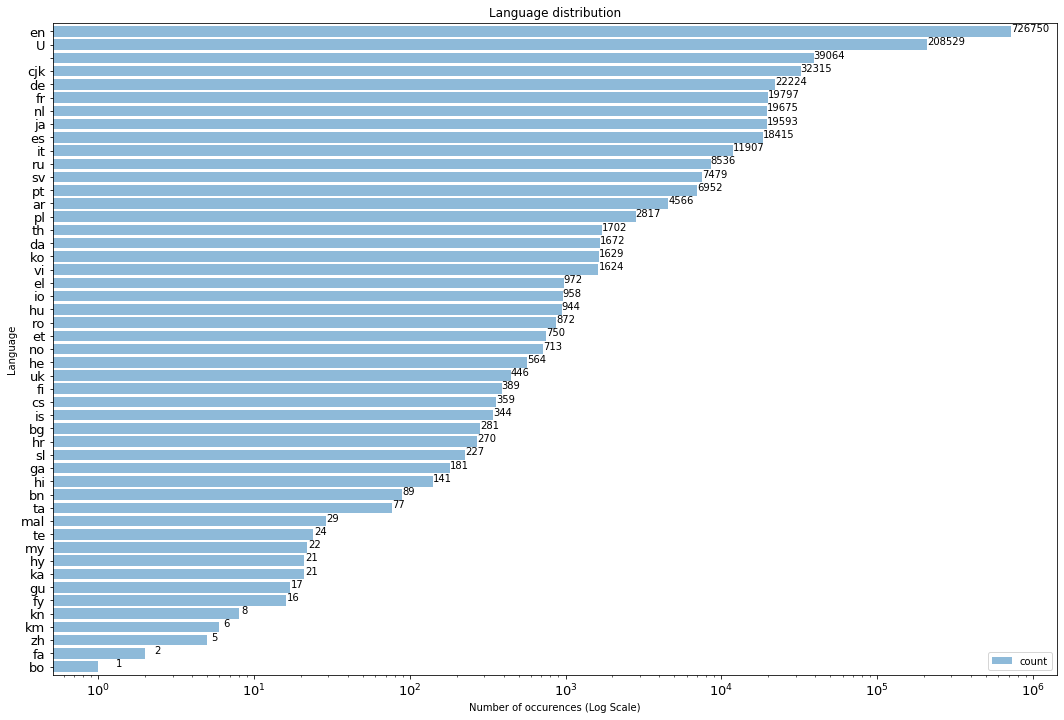

In [46]:
#langCount = feed_entries.groupBy("language").agg(count("*").alias("count")).orderBy("count").toPandas()
langCount = pd.read_pickle("langCount.pkl")
ax = langCount.plot(kind="barh", x="language", y="count", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Language")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Language distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

In [11]:
unknown = feed_entries.filter((feed_entries.language=='U') | (feed_entries.language == ''))

In [12]:
unknown.count()

247593

As we can see, we have a multitude of languages in our dataset. The language 'U' and ' ' correspond to unknown languages in the dataset so we use the langdetect library to find the correct language as they represent almost 20% of our dataset.

In [13]:
@udf('string')
def find_language(content):
    try :
        return detect(content)
    except Exception:
        return ''
    

In [14]:
unknown = unknown.withColumn('language',find_language('cleaned_content'))

In [15]:
corrected_feedEntries= feed_entries.filter((feed_entries.language!= 'U') & (feed_entries.language != '')).union(unknown)
corrected_feedEntries = corrected_feedEntries.filter((corrected_feedEntries.cleaned_content != '') & (corrected_feedEntries.language != ''))

We also notice that one of the language codes is "cjk" which regroups various languages, especially asian languages such as chinese, japanese or korean. Later in this notebook we need to do some translations, and since the Google Translation API doesn't recognize the code "cjk", we use the `langdetect` package to determine the correct language.

In [16]:
asian = corrected_feedEntries.filter((corrected_feedEntries.language=='cjk'))
asian = asian.withColumn('language',find_language('cleaned_content'))
corrected_feedEntries= corrected_feedEntries.filter(corrected_feedEntries.language != "cjk").union(asian)
corrected_feedEntries.cache()

DataFrame[authorEmail: string, authorName: string, dateFound: string, identifier: string, language: string, lastPublished: string, title: string, url: string, publisherType: string, cleaned_content: string]

Now we can plot the language distribution with the newly detected languages:

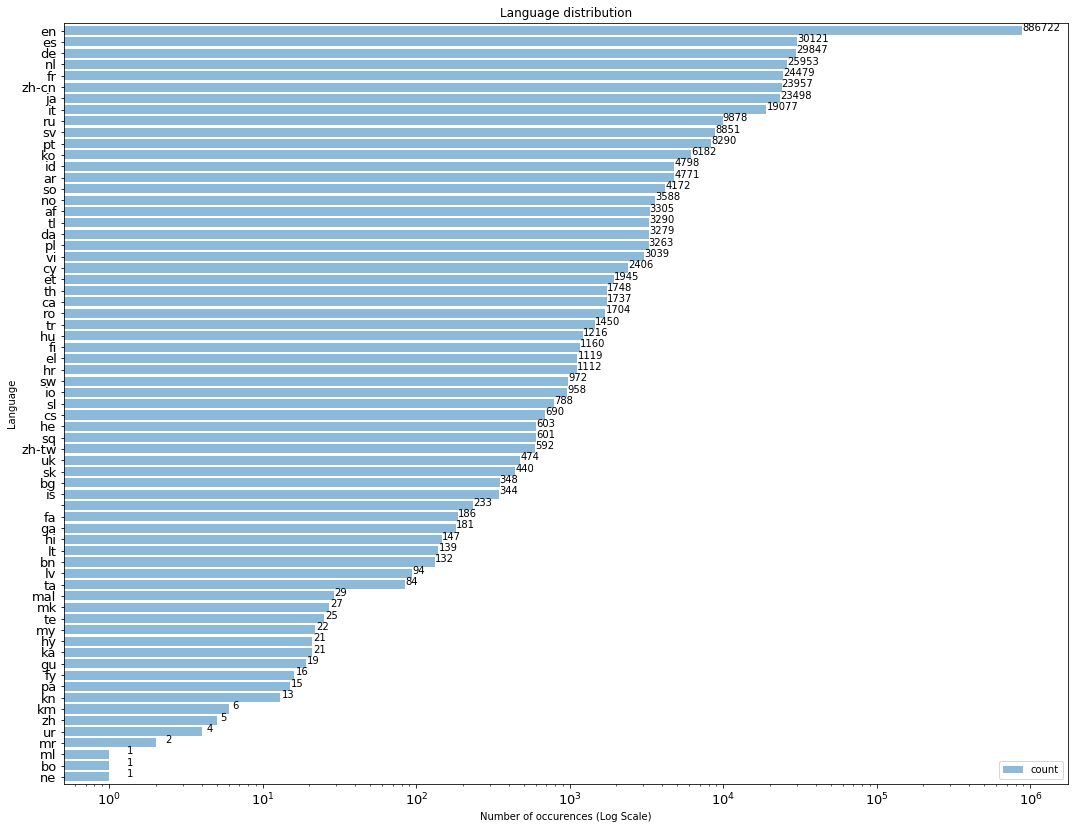

In [141]:
#correctedLangCount = corrected_feedEntries.groupBy("language").agg(count("*").alias("count")).orderBy("count").toPandas()
#correctedLangCount.to_pickle("correctedLangCount.pkl")
correctedLangCount = pd.read_pickle("correctedLangCount.pkl")
ax = correctedLangCount.plot(kind="barh", x="language", y="count", figsize=(18,14), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Language")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Language distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

We decided to keep only the european languages and the Arab one, in order to aswer our resarch question.


In [17]:
europe_lang = list(pd.read_csv("data/europeLang",header = None)[0])

In [18]:
@udf("boolean")
def filter_by_language(language):
    return language in europe_lang

In [19]:
corrected_feedEntries = corrected_feedEntries.filter(filter_by_language(corrected_feedEntries.language))

We also plotted the publisherType distribution. The publisherType attribute is the type of the entry (ex: Social media, blog post, mainstream news....)

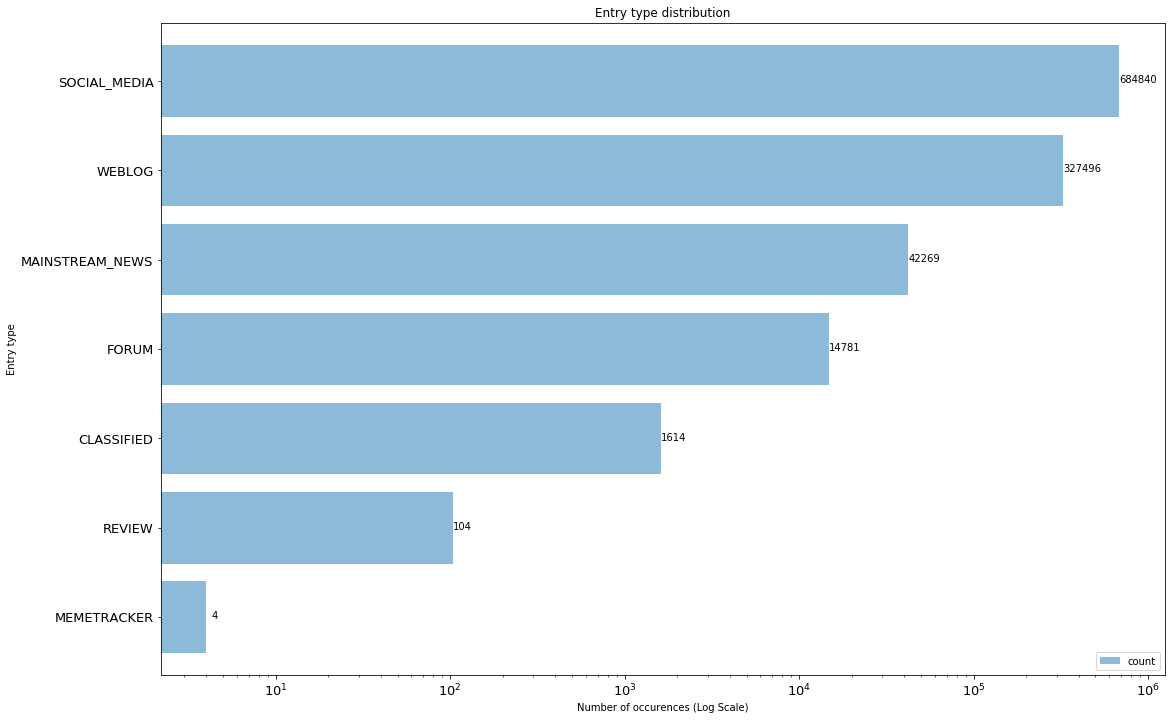

In [135]:
#pubType = corrected_feedEntries.groupBy("publisherType").agg(count("*").alias("count")).orderBy("count").toPandas()
pubType = pd.read_pickle("data/publisherType.pkl")
ax = pubType.plot(kind="barh", x="publisherType", y="count", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Entry type")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Entry type distribution")
for i in ax.patches:²
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

## Discerning an Arab Spring related entries

### Latent Semantic Analysis (LSA)

In this part, we implemented an LSA model in order to find if an entry was related to the Arab Spring or not. LSA extract principal concepts of a corpus, similarly to a PCA, using the SVD decomposition of a TFIDF matrix. It is then possible to compute the similarity between the corpus and a new document.

#### Utility functions

In [6]:
#Clean a text, removes all non english caracters, removes the end of line, and lowers the text
def clean(s):
    return ''.join([i if ord(i) < 128 else '' for i in s]).replace('\n', ' ').lower()

#Removes words from a query that are not in the tfidf model vocabulary
def remove_non_frequent_words(text):
    resultwords  = [x for x in text.split() if x in vectorizer.vocabulary_]
    return ' '.join(resultwords)

#Computes the tfidf vector for a given query
def to_tfidf_vector(query):
    query = remove_non_frequent_words(query.lower().translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))))
    return  vectorizer.transform([query]).todense().tolist()[0]

# COmputes the cosine similarity between two vectors
def cos_sim(a,b):
    if(norm(a)==0):
        return 0
    return (np.dot(a, b)/(norm(a)*norm(b)))[0,0]


#Computation of similarity of the query to the relevant documents

#This function compute the average similarity
def average_computation(vector):
    return np.mean(all_sims(vector))

# This function returns all similarities
def all_sims(vector):
    sims = []
    for i in range(len(revolution_corpus)):
        sim = cos_sim(vector,vh_k[:,i])
        print("Document",doc_names[i],": ",sim)
        sims.append(sim)
    return sims

def compute_similarity(query):
    
    vector1 = to_tfidf_vector(query)
    
    index = np.argwhere(np.array(vector1) >0).squeeze()
    print("Words of the query in the vocabulary:")
    v = vectorizer.vocabulary_
    print([x for x in v if v[x] in index],'\n')
    
    final_query = np.array(vector1).dot(multiplier)
    return average_computation(final_query)

#### Corpus creation

We used wikipedia articles to create a revolution corpus of the arab spring in different countries, and a negative corpus unrelated to these events. 

In [6]:
Arab_Spring = clean(wikipedia.page("Arab Spring").content)
Egyptian_revolution = clean(wikipedia.page("Egyptian revolution of 2011").content)
Tunisian_revolution = clean(wikipedia.page("Tunisian Revolution").content)
Algerian_revolution = clean(wikipedia.page("2010–12 Algerian protests").content)
Moroccan_revolution = clean(wikipedia.page("2011–12 Moroccan protests").content)
Yemeni_Revolution = clean(wikipedia.page("Yemeni Revolution").content)


with open('data/nat_geo.txt', 'r') as file:
    nat_geo = file.read().replace('\n', '')
nat_geo = clean(nat_geo)

revolution_corpus = [Arab_Spring, Egyptian_revolution, Tunisian_revolution, Algerian_revolution, Moroccan_revolution,nat_geo,Yemeni_Revolution]


In [143]:
holiday = clean(wikipedia.page("Holiday").content)
japan_korea = clean(wikipedia.page("2019 Japan-South Korea trade dispute").content)
sport = clean(wikipedia.page("Sport").content)
hank =  clean(wikipedia.page("Hank Marino").content)
art = clean(wikipedia.page("Art").content)
IBM = clean(wikipedia.page("IBM").content)
meteo = clean(wikipedia.page("Weather Forecasting").content)
social_media = clean(wikipedia.page("Social Media").content)
negative_corpus = [holiday, japan_korea,sport,hank,art,IBM,social_media]

for i in range(150):
    os.system('clear')
    try:
        negative_corpus.append(clean(wikipedia.page(wikipedia.random()).content))
    except:
        #In case of an ambiguous page name, we just find a new one
        i = i -1
    
print("Done")

Done


In [57]:
doc_names = ["Arab Spring","Egyptian Revolution","Tunisian Revolution","Algerian Revolution","Morrocan Revolution","Nat Geo Article","Yemeni Revolution"]

In [33]:
corpus = revolution_corpus + negative_corpus
number_documents =  len(corpus)

In [36]:
stopWords = set(nltk.corpus.stopwords.words('english'))

#### Data cleaning and non frequent words removal

In [42]:
for i in range(len(corpus)):
    counter= CountVectorizer(analyzer = "word", stop_words=stopWords)
    V = counter.fit_transform([corpus[i]]).todense().tolist()[0]
    indices = np.argwhere(np.array(V)>6).squeeze()
    vocab = counter.vocabulary_
    words = [x for x in vocab if vocab[x] in indices and not x.isdigit()]
    
    frequent_words  = [x for x in corpus[i].split() if x in words]
    corpus[i] = ' '.join(frequent_words)

#### TFIDF 

In [43]:
vectorizer = TfidfVectorizer(analyzer ="word")
X = vectorizer.fit_transform(corpus).T

#### SVD Decomposition and principle components selection

In [59]:
u, s, vh = np.linalg.svd(X.todense())
print(s)

[1.72348071e+00 1.37028552e+00 1.27570033e+00 1.22108492e+00
 1.17677740e+00 1.13614030e+00 1.13093277e+00 1.13022699e+00
 1.12548675e+00 1.10398274e+00 1.09488978e+00 1.09403455e+00
 1.08504964e+00 1.06981046e+00 1.05382079e+00 1.04907457e+00
 1.04097608e+00 1.03138857e+00 1.02498261e+00 1.02059742e+00
 1.01866193e+00 1.01525020e+00 1.01269371e+00 1.00888592e+00
 1.00311513e+00 1.00203151e+00 1.00139814e+00 1.00086154e+00
 1.00057008e+00 1.00012380e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

In [62]:
# We keep only the principal components of the SVD decomposition
s = s[s>1.02]
dimension = len(s)

u_k = u[:,:dimension]
vh_k = vh[:dimension,:]

In [63]:
#Used in the function compute_similarity
multiplier = u_k.dot(np.linalg.inv(np.diag(s)))

In [64]:
content = corrected_feedEntries.filter(corrected_feedEntries.language == 'en').select("cleaned_content").collect()

We tried to tune is as much as possible, and we tried a lot of different ways to improve it, but unfortunately we were not able to have consistent and good results with this model. We have a lot of false negatives and false positives. For example, in the next cell we can see that documents that should be classified as Arab Spring related only get a 0.5/1 similarity which is clearly not enough.

In [67]:
i=0
for elem in content:
    for word in ['Tunisia','Tunis','tunisian','egypt','riots','protests']:
        if word in elem[0].split(' '):

            i += 1
            
            print("\n Average Similarity:",compute_similarity(elem[0]),'\n')
            break
print(i)

Words of the query in the vocabulary:
['protests', 'announced', 'like', 'charles', 'hall', 'magic'] 

Document Arab Spring :  0.45708392333221387
Document Egyptian Revolution :  0.6575691415739321
Document Tunisian Revolution :  0.8230690263111091
Document Algerian Revolution :  0.7912320944838005
Document Morrocan Revolution :  0.7473449666758039
Document Nat Geo Article :  0.6440489315514661
Document Yemeni Revolution :  0.7551217377597887

 Average Similarity: 0.6964956888125877 

Words of the query in the vocabulary:
['egyptian', 'egypt', 'class', 'better', 'friends', 'making', 'family', 'life'] 

Document Arab Spring :  0.8925615945790104
Document Egyptian Revolution :  0.8429062151258975
Document Tunisian Revolution :  0.47142479827230055
Document Algerian Revolution :  0.18197419596179956
Document Morrocan Revolution :  0.09197847115007193
Document Nat Geo Article :  0.5783595394617138
Document Yemeni Revolution :  0.44429314992896746

 Average Similarity: 0.5004997092113944 

W

In the other hand, some queries that should not be classified as Arab Spring related obtained extremely high scores. ( 0.9/1)

### Keyword Extraction

As this method was non conclusive, we decided to manualy extract keywords representing the Arab SPring, and to filter out alll entries having less than 3 keywords.

#### Keywords translation

This function was used in an external script to translate the keywords into all the european languages.

In [42]:
# With this function, we translate every keywords in the top languages
def keywords_translation(lang_list):
    keywords = list(pd.read_csv('keywords.csv',header = None)[0])
    translator = Translator()
    for language in lang_list:
            translations = translator.translate(keywords, dest=language)
            translated_keywords = []
            for tr in translations:
                translated_keywords.append(tr.text)
            with open("translated_keywords.csv", 'a') as f:
                writer = csv.writer(f,delimiter = ';')
                writer.writerow(translated_keywords)

In [84]:
keywords = pd.read_csv("data/translated_keywords.csv")
keywords = keywords.applymap(str.lower)

In [88]:
#Returns true if the word is related to the arab spring
@udf("boolean")
def filter_keywords(word, language):
    kw = list(keywords[language])
    clean_word = word.lower().translate(str.maketrans("","", string.punctuation))
    return clean_word  in kw

#### Tokenize the content of the entries and stopwords removal

In [7]:
corrected_feedEntries.write.json("data/corrected_entries.json")

In [4]:
corrected_feedEntries = spark.read.json("data/corrected_entries.json")

In [5]:
@udf("string")
def concat_title_content(title,content):
    return title +" "+ content

In [6]:
corrected_feedEntries = corrected_feedEntries.withColumn("cleaned_content", concat_title_content(corrected_feedEntries.title,corrected_feedEntries.cleaned_content))

In [92]:
regexTokenizer = RegexTokenizer(inputCol="cleaned_content", outputCol="words", pattern="\\W")
entries = regexTokenizer.transform(corrected_feedEntries)

In [93]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered words")
entries = remover.transform(entries).drop("words")

#### FIltering the data to keep only Arab spring related entries

In [94]:
exploded_entries = entries.select("lastPublished","title","publisherType","language",
                                    explode(entries["filtered words"]).alias("word"))

In [95]:
# We filter out the non arab spring related words, and keep only the entries containing strictly more than 2 words
entries = exploded_entries.filter(filter_keywords(exploded_entries["word"], exploded_entries.language))

In [96]:
entries = entries.groupBy("lastPublished","title","publisherType", "language").agg(collect_set("word").alias("keywords"))

### Computing recall and precision 

#### Helper functions

In [8]:
def color(val):
    if val == true_positives or val == true_negatives:
        return "background-color: chartreuse"
    else: return "background-color: red"
    
    
def print_stats(false_positives,false_negatives,true_positives,true_negatives):
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_negatives + false_positives) #(len(values)+len(negatives_values))
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    F1 = 2* precision*recall / (precision+recall)
    
    print("Accuracy: ",accuracy)
    print("F1 score: ",F1)
    print("Recall: ", recall)
    print("Precision: ",precision)
    return pd.DataFrame(data=[[true_positives,false_positives],[false_negatives,true_negatives]], \
                       index= ["Classified as Arab Spring related ",'Classified as Non related'], \
                       columns= ["Arab Spring related",'Non related']) \
                    .style.applymap(color)

def compute_values(data):
    values = []
    for elem in data['title']:
        try: 
            print(elem, flush = True)
            number = input()
            values.append(int(number))
            os.system('clear')
        except:
            break

    trues = len(np.argwhere(values))
    falses = len(values) - trues
    return trues,falses

#### First filtering of the data to only get data with at least one word in the keywords

In [98]:
filtered_entries_1 = entries.filter(size(entries.keywords) >=1)

In [99]:
data_1 = filtered_entries_1.sample(100/filtered_entries_1.count())

In [100]:
data_1 = data_1.toPandas()

In [101]:
data_1['length'] = data_1["keywords"].map(len)

#### Testing with the treshold at more than 2 keywords

In [5]:
#data_1 = pd.read_csv("data_1.csv")

In [102]:
threshold = 2

In [103]:
test1 = data_1[data_1["length"]>threshold]
true_positives,false_positives = compute_values(test1)

Thousands demand ouster of Yemen’s president 
    (AP)


 1


Postcard From a Free Egypt


 0


Police, protesters clash at Algerian democracy rally


 1


Marchers Plan Second Egypt Solidarity Rally By UN


 1


Key members of Egypt's ruling party resign


 1


Uganda opposition threatens Egypt-style protests


 1


Nigerian President Goodluck Jonathan to seek one term


 0


Questions for Egypt: After the Revolution who has the Solution? Who will emerge as the face of Democracy? How does this transition to democracy protect the country from insurgency? How will this affect the ties between the U.S. and Israel? Will the ballot


 1


Whether Mubarak Realizes It or Not, the Light Has Served Notice on the Dark to Go


 1


Lessons From Tunisia


 1


L'Egypte se prépare à la 'marche du million' de l'opposition


 1


Statement by H.E. Mohamed Abdullahi Mohamed Prime Minister of Somalia at UN Security Council Meeting on Somalia


 0


In [104]:
test2 = data_1[data_1["length"]<=threshold]
false_negatives, true_negatives = compute_values(test2)

72
Unsere deutschen Fussballvereine und Mannschaften :: RE: SV Sandhausen


 0


Wired & Shrewd, Young Egyptians Guide Revolt; The Truth about Egypt's (gov) Lies; Revolutionary Humor + more: http://bit.ly/CSTumblr #Jan25


 1


Jiménez remonta… pero no lo suficiente


 0


Local group protests Shiner's Circus


 0


Algeria's 1992 state of emergency to be lifted


 0


army navy game 2010


 0


Laura Bozzo estara en ringtone de celular


 0


Choose words with great care


 0


Confindustria: le banche continuino a credere nelle nostre piccole imprese.


 0


Book Review: The Renewable Revolution


 0


Tunísia: Presidente de transição promete romper com o passado


 1


Social Media Revolution SEO/ SEM Social Marketing Kino Walker Canada


 0


'The King's Speech': Talk Live To Stars Colin Firth, Guy Pearce, Helena Bonham Carter And Claire Bloom


 0


Blue America's newest Health Care Hypocrite, Leonard Lance exposed for carrying taxpayer-funded insurance


 0


British War Criminals Indicted By their own Attorney General - http://bit.ly/BritishWarCriminals 


 0


George Lucas


 0


CIA chief says looks like Mubarak about to quit


 1


Australia towns face once-in-200-year floods


 0


Digressão de domingo


 0


"Morovach - Cellule de Crise" Découvrez 08 Morceaux Extraits du Projet du Groupe ...

http://www.passionhiphop.fr/sons-Rap-2009-Historique/Morovach-Cellule-de-Crise,2676.html


 0


ihave a best friend of the opposite sex, and they mean the whoLe worLd to me. we do not fancy each other and yes, we do Lauqh toqether. that isn't fLirtinq, its caLLed aa joke. iCan teLLl them secrets and they wiLLl keep them, ican trust him with my Life 


 0


Ramblings and Rules Question


 0


Radical Iraqi cleric travels back to Iran


 0


ITHANK GOD 4 2 DAY AND PRAY 2 C 2MARROW..LOVE MY LIFE AND FAMILY.SN:IKNW SUM 0F YALL L0ST A LOVE 0NE S0 GNE SHED DEM TEAR KUZ IKN0 U "KANT HOLD IT IN N0 M0" AND MY L0VE 2 YA KUZ IKN0 ITS HARD AND MITE N0T SEEM FAIR BUT GOD NEEDS HIS ARMY AND ITS KUMN TYME


 0


NEWS:Segelkunstflug EM Pasewalk  ()


 0


Iraq PM vows not to seek third term: AFP interview 
    (AFP)


 0


Why did Joe Biden rush to visit Pakistan?


 0


La France opposée à un supplément de fonds propres


 0


Gutschein "myStofftier"


 0


Battles in Tunis as new government takes shape


 1


Exportkennzeichen Versicherung Irak online günstig


 0


Uday Hussein


 0


NEW YORK – NOVEMBRO DE 2010


 0


Iran: attacco a siti Guida suprema


 0


4-0 at the MBS prerelease (first time in my life!)


 0


Tunisie: La Fortune De Ben Ali En Question


 1


Ruim 20.000 studenten demonstreren tegen onderwijsplannen


 0


RT @tfjtolson: Photo of Egyptian protester kissing a riot officer is incredible: http://j.mp/h0h48k. Wow. We are all one & want the same thing - freedom.


 1


Filmes em Sundance expõem vidas secretas no Iraque e Irã


 0


!!!.DIOBRAL MURAH GRATIS ALAT TERAPI KESEHATAN..!!!


 0


Southern Sudan edges closer to independence


 1


Mubarak Mystery: In Egypt, In Germany, In Coma?


 1


I am against this guy who is causing pandemonium in Egypt. For the records,he was in America for morethan 15 years,he claims the presidencyship. I think this clown should get a life.


 1


Superbe blonde à gros seins prise en levrette


 0


AllesAnna – 10,00 EUR Rabatt


 0


Revolution in the fog


 0


The last 4 Days...


 0


FTSE tipped to start week with firm gains on Egypt optimism


 0


I know you heard about the dream... But im ready for the Revolution! 


 0


Tunisia's embattled president surrenders power


 1


Qatar stuurt bondscoach Metsu de laan uit


 0


[NEWS] PlayStation 3: Rootkit in Firmware 3.56? [UPDATE]


 0


today on the news forclosors are up 35% but there from the men and weman that defend our country over seas in Iraq and afgan one of the co JP morgan are throwing the familys out while there husband or wifes are figthing for our freedom they should be drag


 0


China says economy grew 10.3% in 2010


 0


What we should we ask of the new UMass president?


 0


16:09 Maroc: une loi contre le hooliganisme bientôt adoptée


 0


Wiederholung der Bergfahrt.


 0


Cidadáns suecos non visitarán Galiza como protesta polas touradas da Coruña


 0


"Land of the free because of﻿ the brave." They love their freedom, but not the people (Soldiers) who fight for it. I spent 15 months in﻿ Iraq and now serving 12 months in Afghanistan. If you cant stand behind us, feel free to stand in front. You go fi


 0


FRANKRIJK: VOLKSWOEDE TUNESIë ONDERSCHAT


 0


[ Cinéma ] Question ouverte : Qui a vu La Guerre des Etoiles ?


 0


Herthas U17 besigt den FC St. Pauli mit 2:0


 0


Biete > Sigma 10-20 4.0-5.6 EX DC HSM


 0


Guess I won't be drinking Starbucks !!!!!!!


 0


Crittenden A Kentucky Story of Love and War


 0


got back from hanging out with Jon =) had a great time. got to watch 2 of the Family Guy Star Wars movies & I finished the rest of my Iris Johansen book! now on to the next one! =) hope ya'll had a fabulous weekend & an even better week!


 0


Nazis terrorisieren Hamburg


 0


And God spake all these words, saying, I am Jehovah thy God, who brought thee out of the land of Egypt, out of the house of bondage. Thou shalt have no other gods before me. Thou shalt not make unto thee a graven image, nor any likeness of any thing that 


 0


Qamarina si hidung penyet. Ayam penyet, hidung penyet. Erk


 0


Matemathic history


 0


Integrare la csr nel business per accelerare ripresa della crisi


 0


North American International Auto Show 2011 in Detroit - Das Auto-Mekka der Vereinigten Staaten


 0


In [105]:
print_stats(false_positives,false_negatives,true_positives,true_negatives)

Accuracy:  0.8452380952380952
F1 score:  0.5806451612903226
Recall:  0.47368421052631576
Precision:  0.75


#### Testing with the treshold at more than 3 keywords

In [106]:
threshold = 3

In [107]:
test1 = data_1[data_1["length"]>threshold]
true_positives,false_positives = compute_values(test1)

Postcard From a Free Egypt


 0


Marchers Plan Second Egypt Solidarity Rally By UN


 1


Key members of Egypt's ruling party resign


 1


Whether Mubarak Realizes It or Not, the Light Has Served Notice on the Dark to Go


 1


L'Egypte se prépare à la 'marche du million' de l'opposition


 1


Statement by H.E. Mohamed Abdullahi Mohamed Prime Minister of Somalia at UN Security Council Meeting on Somalia


 0


In [108]:
test2 = data_1[data_1["length"]<=threshold]
false_negatives,true_negatives = compute_values(test2)

Unsere deutschen Fussballvereine und Mannschaften :: RE: SV Sandhausen


 0


Wired & Shrewd, Young Egyptians Guide Revolt; The Truth about Egypt's (gov) Lies; Revolutionary Humor + more: http://bit.ly/CSTumblr #Jan25


 1


Jiménez remonta… pero no lo suficiente


 0


Local group protests Shiner's Circus


 0


Thousands demand ouster of Yemen’s president 
    (AP)


 1


Algeria's 1992 state of emergency to be lifted


 0


army navy game 2010


 0


Laura Bozzo estara en ringtone de celular


 0


Choose words with great care


 0


Confindustria: le banche continuino a credere nelle nostre piccole imprese.


 0


Book Review: The Renewable Revolution


 0


Tunísia: Presidente de transição promete romper com o passado


 1


Social Media Revolution SEO/ SEM Social Marketing Kino Walker Canada


 0


'The King's Speech': Talk Live To Stars Colin Firth, Guy Pearce, Helena Bonham Carter And Claire Bloom


 0


Blue America's newest Health Care Hypocrite, Leonard Lance exposed for carrying taxpayer-funded insurance


 0


British War Criminals Indicted By their own Attorney General - http://bit.ly/BritishWarCriminals 


 0


George Lucas


 0


CIA chief says looks like Mubarak about to quit


 1


Australia towns face once-in-200-year floods


 0


Digressão de domingo


 0


"Morovach - Cellule de Crise" Découvrez 08 Morceaux Extraits du Projet du Groupe ...

http://www.passionhiphop.fr/sons-Rap-2009-Historique/Morovach-Cellule-de-Crise,2676.html


 0


ihave a best friend of the opposite sex, and they mean the whoLe worLd to me. we do not fancy each other and yes, we do Lauqh toqether. that isn't fLirtinq, its caLLed aa joke. iCan teLLl them secrets and they wiLLl keep them, ican trust him with my Life 


 0


Ramblings and Rules Question


 0


Police, protesters clash at Algerian democracy rally


 1


Radical Iraqi cleric travels back to Iran


 0


ITHANK GOD 4 2 DAY AND PRAY 2 C 2MARROW..LOVE MY LIFE AND FAMILY.SN:IKNW SUM 0F YALL L0ST A LOVE 0NE S0 GNE SHED DEM TEAR KUZ IKN0 U "KANT HOLD IT IN N0 M0" AND MY L0VE 2 YA KUZ IKN0 ITS HARD AND MITE N0T SEEM FAIR BUT GOD NEEDS HIS ARMY AND ITS KUMN TYME


 0


NEWS:Segelkunstflug EM Pasewalk  ()


 0


Iraq PM vows not to seek third term: AFP interview 
    (AFP)


 0


Why did Joe Biden rush to visit Pakistan?


 0


La France opposée à un supplément de fonds propres


 0


Gutschein "myStofftier"


 0


Battles in Tunis as new government takes shape


 1


Exportkennzeichen Versicherung Irak online günstig


 0


Uday Hussein


 0


NEW YORK – NOVEMBRO DE 2010


 0


Iran: attacco a siti Guida suprema


 0


4-0 at the MBS prerelease (first time in my life!)


 0


Tunisie: La Fortune De Ben Ali En Question


 1


Ruim 20.000 studenten demonstreren tegen onderwijsplannen


 0


RT @tfjtolson: Photo of Egyptian protester kissing a riot officer is incredible: http://j.mp/h0h48k. Wow. We are all one & want the same thing - freedom.


 1


Uganda opposition threatens Egypt-style protests


 1


Nigerian President Goodluck Jonathan to seek one term


 0


Questions for Egypt: After the Revolution who has the Solution? Who will emerge as the face of Democracy? How does this transition to democracy protect the country from insurgency? How will this affect the ties between the U.S. and Israel? Will the ballot


 1


Filmes em Sundance expõem vidas secretas no Iraque e Irã


 0


!!!.DIOBRAL MURAH GRATIS ALAT TERAPI KESEHATAN..!!!


 0


Southern Sudan edges closer to independence


 1


Mubarak Mystery: In Egypt, In Germany, In Coma?


 1


I am against this guy who is causing pandemonium in Egypt. For the records,he was in America for morethan 15 years,he claims the presidencyship. I think this clown should get a life.


 1


Lessons From Tunisia


 1


Superbe blonde à gros seins prise en levrette


 0


AllesAnna – 10,00 EUR Rabatt


 0


Revolution in the fog


 0


The last 4 Days...


 0


FTSE tipped to start week with firm gains on Egypt optimism


 0


I know you heard about the dream... But im ready for the Revolution! 


 0


Tunisia's embattled president surrenders power


 1


Qatar stuurt bondscoach Metsu de laan uit


 0


[NEWS] PlayStation 3: Rootkit in Firmware 3.56? [UPDATE]


 0


today on the news forclosors are up 35% but there from the men and weman that defend our country over seas in Iraq and afgan one of the co JP morgan are throwing the familys out while there husband or wifes are figthing for our freedom they should be drag


 0


China says economy grew 10.3% in 2010


 0


What we should we ask of the new UMass president?


 0


16:09 Maroc: une loi contre le hooliganisme bientôt adoptée


 0


Wiederholung der Bergfahrt.


 0


Cidadáns suecos non visitarán Galiza como protesta polas touradas da Coruña


 0


"Land of the free because of﻿ the brave." They love their freedom, but not the people (Soldiers) who fight for it. I spent 15 months in﻿ Iraq and now serving 12 months in Afghanistan. If you cant stand behind us, feel free to stand in front. You go fi


 0


FRANKRIJK: VOLKSWOEDE TUNESIë ONDERSCHAT


 0


[ Cinéma ] Question ouverte : Qui a vu La Guerre des Etoiles ?


 0


Herthas U17 besigt den FC St. Pauli mit 2:0


 0


Biete > Sigma 10-20 4.0-5.6 EX DC HSM


 0


Guess I won't be drinking Starbucks !!!!!!!


 0


Crittenden A Kentucky Story of Love and War


 0


got back from hanging out with Jon =) had a great time. got to watch 2 of the Family Guy Star Wars movies & I finished the rest of my Iris Johansen book! now on to the next one! =) hope ya'll had a fabulous weekend & an even better week!


 0


Nazis terrorisieren Hamburg


 0


And God spake all these words, saying, I am Jehovah thy God, who brought thee out of the land of Egypt, out of the house of bondage. Thou shalt have no other gods before me. Thou shalt not make unto thee a graven image, nor any likeness of any thing that 


 0


Qamarina si hidung penyet. Ayam penyet, hidung penyet. Erk


 0


Matemathic history


 0


Integrare la csr nel business per accelerare ripresa della crisi


 0


North American International Auto Show 2011 in Detroit - Das Auto-Mekka der Vereinigten Staaten


 0


In [109]:
print_stats(false_positives,false_negatives,true_positives,true_negatives)

Accuracy:  0.7976190476190477
F1 score:  0.32
Recall:  0.21052631578947367
Precision:  0.6666666666666666


#### Testing with the treshold at more than 1 keywords

In [111]:
threshold = 1

In [112]:
test1 = data_1[data_1["length"]>threshold]
true_positives,false_positives = compute_values(test1)

Wired & Shrewd, Young Egyptians Guide Revolt; The Truth about Egypt's (gov) Lies; Revolutionary Humor + more: http://bit.ly/CSTumblr #Jan25


 1


Thousands demand ouster of Yemen’s president 
    (AP)


 1


CIA chief says looks like Mubarak about to quit


 1


Postcard From a Free Egypt


 1


Police, protesters clash at Algerian democracy rally


 1


Radical Iraqi cleric travels back to Iran


 0


Marchers Plan Second Egypt Solidarity Rally By UN


 1


Battles in Tunis as new government takes shape


 1


Iran: attacco a siti Guida suprema


 0


Key members of Egypt's ruling party resign


 1


Uganda opposition threatens Egypt-style protests


 1


Nigerian President Goodluck Jonathan to seek one term


 0


Questions for Egypt: After the Revolution who has the Solution? Who will emerge as the face of Democracy? How does this transition to democracy protect the country from insurgency? How will this affect the ties between the U.S. and Israel? Will the ballot


 1


Whether Mubarak Realizes It or Not, the Light Has Served Notice on the Dark to Go


 1


Southern Sudan edges closer to independence


 1


Mubarak Mystery: In Egypt, In Germany, In Coma?


 1


Lessons From Tunisia


 1


L'Egypte se prépare à la 'marche du million' de l'opposition


 1


Tunisia's embattled president surrenders power


 1


Nazis terrorisieren Hamburg


 0


Qamarina si hidung penyet. Ayam penyet, hidung penyet. Erk


 0


Matemathic history


 0


Statement by H.E. Mohamed Abdullahi Mohamed Prime Minister of Somalia at UN Security Council Meeting on Somalia


 0


In [113]:
test2 = data_1[data_1["length"]<=threshold]
false_negatives,true_negatives = compute_values(test2)

Unsere deutschen Fussballvereine und Mannschaften :: RE: SV Sandhausen


 0


Jiménez remonta… pero no lo suficiente


 0


Local group protests Shiner's Circus


 0


Algeria's 1992 state of emergency to be lifted


 0


army navy game 2010


 0


Laura Bozzo estara en ringtone de celular


 0


Choose words with great care


 0


Confindustria: le banche continuino a credere nelle nostre piccole imprese.


 0


Book Review: The Renewable Revolution


 0


Tunísia: Presidente de transição promete romper com o passado


 1


Social Media Revolution SEO/ SEM Social Marketing Kino Walker Canada


 0


'The King's Speech': Talk Live To Stars Colin Firth, Guy Pearce, Helena Bonham Carter And Claire Bloom


 0


Blue America's newest Health Care Hypocrite, Leonard Lance exposed for carrying taxpayer-funded insurance


 0


British War Criminals Indicted By their own Attorney General - http://bit.ly/BritishWarCriminals 


 0


George Lucas


 0


Australia towns face once-in-200-year floods


 0


Digressão de domingo


 0


"Morovach - Cellule de Crise" Découvrez 08 Morceaux Extraits du Projet du Groupe ...

http://www.passionhiphop.fr/sons-Rap-2009-Historique/Morovach-Cellule-de-Crise,2676.html


 0


ihave a best friend of the opposite sex, and they mean the whoLe worLd to me. we do not fancy each other and yes, we do Lauqh toqether. that isn't fLirtinq, its caLLed aa joke. iCan teLLl them secrets and they wiLLl keep them, ican trust him with my Life 


 0


Ramblings and Rules Question


 0


ITHANK GOD 4 2 DAY AND PRAY 2 C 2MARROW..LOVE MY LIFE AND FAMILY.SN:IKNW SUM 0F YALL L0ST A LOVE 0NE S0 GNE SHED DEM TEAR KUZ IKN0 U "KANT HOLD IT IN N0 M0" AND MY L0VE 2 YA KUZ IKN0 ITS HARD AND MITE N0T SEEM FAIR BUT GOD NEEDS HIS ARMY AND ITS KUMN TYME


 0


NEWS:Segelkunstflug EM Pasewalk  ()


 0


Iraq PM vows not to seek third term: AFP interview 
    (AFP)


 0


Why did Joe Biden rush to visit Pakistan?


 0


La France opposée à un supplément de fonds propres


 0


Gutschein "myStofftier"


 0


Exportkennzeichen Versicherung Irak online günstig


 0


Uday Hussein


 0


NEW YORK – NOVEMBRO DE 2010


 0


4-0 at the MBS prerelease (first time in my life!)


 0


Tunisie: La Fortune De Ben Ali En Question


 1


Ruim 20.000 studenten demonstreren tegen onderwijsplannen


 0


RT @tfjtolson: Photo of Egyptian protester kissing a riot officer is incredible: http://j.mp/h0h48k. Wow. We are all one & want the same thing - freedom.


 1


Filmes em Sundance expõem vidas secretas no Iraque e Irã


 0


!!!.DIOBRAL MURAH GRATIS ALAT TERAPI KESEHATAN..!!!


 0


I am against this guy who is causing pandemonium in Egypt. For the records,he was in America for morethan 15 years,he claims the presidencyship. I think this clown should get a life.


 1


Superbe blonde à gros seins prise en levrette


 0


AllesAnna – 10,00 EUR Rabatt


 0


Revolution in the fog


 0


The last 4 Days...


 0


FTSE tipped to start week with firm gains on Egypt optimism


 0


I know you heard about the dream... But im ready for the Revolution! 


 0


Qatar stuurt bondscoach Metsu de laan uit


 0


[NEWS] PlayStation 3: Rootkit in Firmware 3.56? [UPDATE]


 0


today on the news forclosors are up 35% but there from the men and weman that defend our country over seas in Iraq and afgan one of the co JP morgan are throwing the familys out while there husband or wifes are figthing for our freedom they should be drag


 0


China says economy grew 10.3% in 2010


 0


What we should we ask of the new UMass president?


 0


16:09 Maroc: une loi contre le hooliganisme bientôt adoptée


 0


Wiederholung der Bergfahrt.


 0


Cidadáns suecos non visitarán Galiza como protesta polas touradas da Coruña


 0


"Land of the free because of﻿ the brave." They love their freedom, but not the people (Soldiers) who fight for it. I spent 15 months in﻿ Iraq and now serving 12 months in Afghanistan. If you cant stand behind us, feel free to stand in front. You go fi


 0


FRANKRIJK: VOLKSWOEDE TUNESIë ONDERSCHAT


 0


[ Cinéma ] Question ouverte : Qui a vu La Guerre des Etoiles ?


 0


Herthas U17 besigt den FC St. Pauli mit 2:0


 0


Biete > Sigma 10-20 4.0-5.6 EX DC HSM


 0


Guess I won't be drinking Starbucks !!!!!!!


 0


Crittenden A Kentucky Story of Love and War


 0


got back from hanging out with Jon =) had a great time. got to watch 2 of the Family Guy Star Wars movies & I finished the rest of my Iris Johansen book! now on to the next one! =) hope ya'll had a fabulous weekend & an even better week!


 0


And God spake all these words, saying, I am Jehovah thy God, who brought thee out of the land of Egypt, out of the house of bondage. Thou shalt have no other gods before me. Thou shalt not make unto thee a graven image, nor any likeness of any thing that 


 0


Integrare la csr nel business per accelerare ripresa della crisi


 0


North American International Auto Show 2011 in Detroit - Das Auto-Mekka der Vereinigten Staaten


 0


In [114]:
print_stats(false_positives,false_negatives,true_positives,true_negatives)

Accuracy:  0.8690476190476191
F1 score:  0.7441860465116279
Recall:  0.8
Precision:  0.6956521739130435


### Full data

In [115]:
filtered_entries = entries.filter(size(entries.keywords) >1).persist()

In [199]:
filtered_entries.show()

+--------------------+--------------------+---------------+--------+--------------------+
|       lastPublished|               title|  publisherType|language|            keywords|
+--------------------+--------------------+---------------+--------+--------------------+
|                    |Egypt may find th...|         WEBLOG|      en|[islamist, sudan,...|
|2011-01-15T18:07:12Z|Arab activists ho...|MAINSTREAM_NEWS|      en|[uprising, arab, ...|
|2011-01-16T10:07:00Z|Tense calm return...|         WEBLOG|      en|[tunisia, arab, o...|
|2011-01-19T17:32:06Z|Tunisia’s Revolut...|         WEBLOG|      en|[tunisia, revolut...|
|2011-01-20T13:00:24Z|Freya Stark: Intr...|         WEBLOG|      en|[islamic, arab, war]|
|2011-01-20T17:45:00Z|Reviews of Atlas ...|         WEBLOG|      en|[tunisia, opposit...|
|2011-02-03T10:40:02Z|BusinessWeek: Oil...|         WEBLOG|      en|[egypt, yemen, pr...|
|2011-02-06T15:34:49Z|Bill Maher Calls ...|         WEBLOG|      en|[opposition, revo...|
|2011-02-0

In [116]:
# Tranfsormation of the date field from string to dateFormat
filtered_entries = filtered_entries.withColumn("lastPublished_dateFormat", to_date(filtered_entries.lastPublished, "yy-MM-dd"))

In [9]:
filtered_entries.write.json('data/filtered_entries.json')

In [10]:
filtered_entries = spark.read.json('data/spinn3r_filtered_data1.json')

In [11]:
filtered_entries.show(30)

+--------------------+--------+-------------+---------------+--------------------+
|            keywords|language|lastPublished|  publisherType|               title|
+--------------------+--------+-------------+---------------+--------------------+
|[egypt, cairo, pr...|      en|             |MAINSTREAM_NEWS|"March of a milli...|
|[crisis, demonstr...|      en|             |         WEBLOG|'Baby Doc' Duvali...|
|     [baghdad, iraq]|      en|             |         WEBLOG|* MP Says: Nation...|
|         [iraq, war]|      en|             |         WEBLOG|* Nighthk11 Chat:...|
|[arabia, egypt, s...|      en|             |         WEBLOG|* SUMMARY: Skype ...|
|[protestos, crise...|      pt|             |         WEBLOG|*Dedé está regula...|
|   [tunisia, arabia]|      it|             |         WEBLOG|06:31 - TUNISIA, ...|
|    [regime, egitto]|      it|             |         WEBLOG|12:27 - "NUOVO" E...|
|[egypt, cairo, eg...|      en|             |         WEBLOG|19th Ain Shams In...|
|   

### Visualization

#### Number of Arab Spring related entries per day

In [12]:
filtered_entries = filtered_entries.withColumn("lastPublished_dateFormat", to_date(filtered_entries.lastPublished, "yy-MM-dd"))

In [13]:
occurences = filtered_entries.groupBy("lastPublished_dateFormat").agg(count('*').alias("occurences")).dropna()

Text(0.5, 1.0, 'Number of Arab Spring related entries per day')

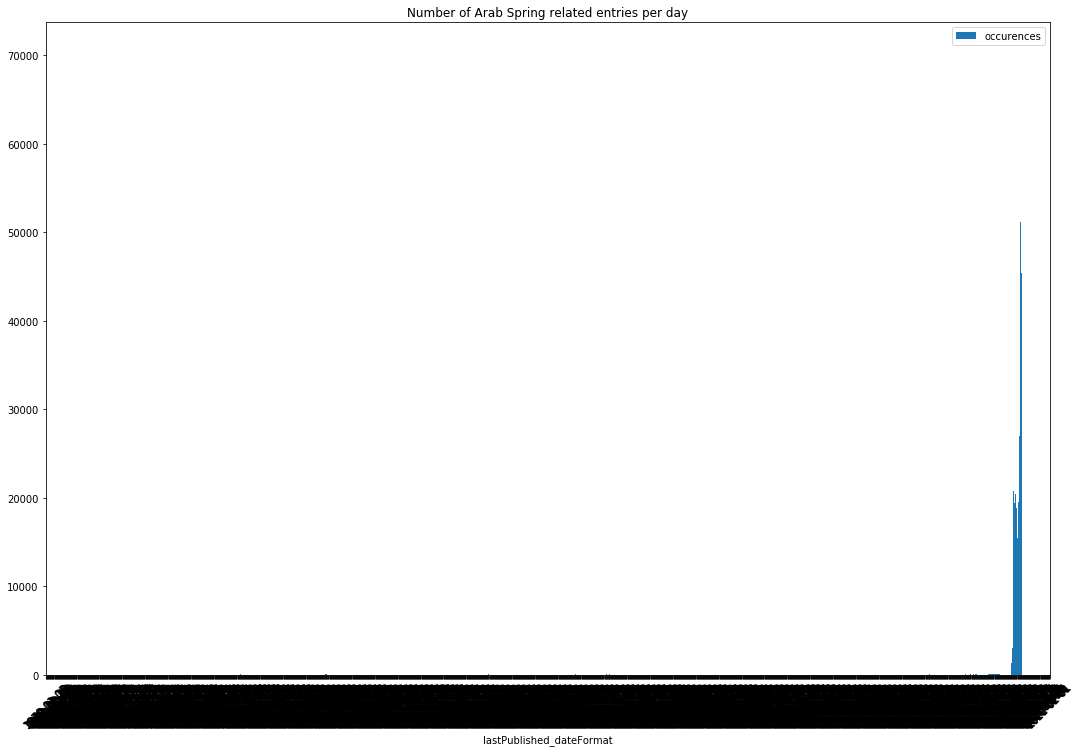

In [14]:
occurence_pd = occurences.toPandas()
#occurence_pd.to_pickle("occurences.pkl")
#occurence_pd = pd.read_pickle("occurences.pkl")
ax = occurence_pd.sort_values(by="lastPublished_dateFormat").plot(kind="bar", x="lastPublished_dateFormat", y="occurences",  figsize=(18,12), rot=45)
plt.title("Number of Arab Spring related entries per day")

We have a lot of unwanted data before january 2011. We need to filter this out.

In [15]:
filtered_entries.filter(filtered_entries.lastPublished_dateFormat<"2010.12.01").show(30)

+--------------------+--------+--------------------+-------------+--------------------+------------------------+
|            keywords|language|       lastPublished|publisherType|               title|lastPublished_dateFormat|
+--------------------+--------+--------------------+-------------+--------------------+------------------------+
|[guerre, crisi, s...|      it|2006-10-04T11:06:08Z|       WEBLOG|            Piemonte|              2006-10-04|
|[crisi, galleria,...|      it|2006-10-19T10:46:36Z|       WEBLOG|             Livorno|              2006-10-19|
|     [arabia, saudi]|      en|2006-11-10T15:50:00Z|       WEBLOG|       What is a VET|              2006-11-10|
|         [iraq, war]|      en|2007-02-17T00:53:00Z|       WEBLOG|               V-day|              2007-02-17|
|         [iraq, war]|      en|2007-02-17T17:33:00Z|       WEBLOG|Congress Votes on...|              2007-02-17|
|         [iraq, war]|      en|2007-03-18T15:29:00Z|       WEBLOG|On this day in hi...|         

These are protests,wars or crisis occuring in the arab world (in Egypt, Sudan, etc..) multiple years before the Arab spring events, hence we deicided to drop these entries. 

In [16]:
filtered_entries = filtered_entries.filter((filtered_entries.lastPublished_dateFormat>"2011-01-01") & (filtered_entries.lastPublished_dateFormat < "2011-02-19"))

Text(0.5, 1.0, 'Number of Arab Spring related entries per day')

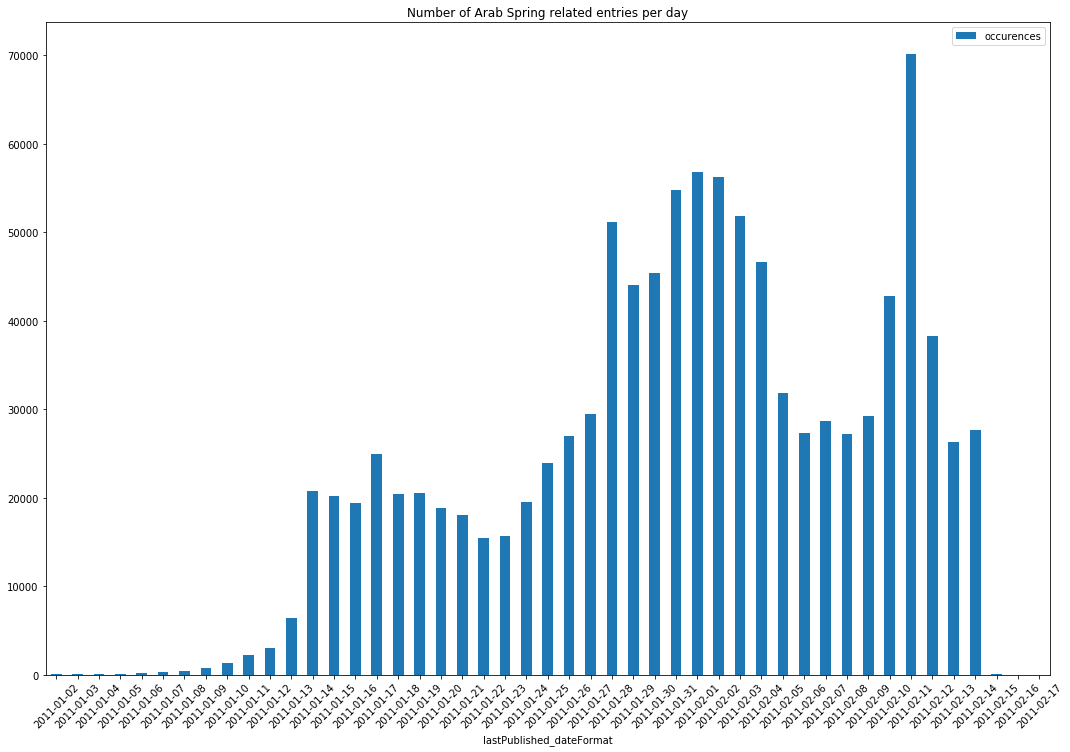

In [17]:
occurences = filtered_entries.groupBy("lastPublished_dateFormat").agg(count('*').alias("occurences")).dropna()
occurence_pd = occurences.toPandas()
#occurence_pd.to_pickle("occurences.pkl")
#occurence_pd = pd.read_pickle("occurences.pkl")
ax = occurence_pd.sort_values(by="lastPublished_dateFormat").plot(kind="bar", x="lastPublished_dateFormat", y="occurences",  figsize=(18,12), rot=45)
plt.title("Number of Arab Spring related entries per day")

In [18]:
occurences_per_lang = filtered_entries.groupBy("lastPublished_dateFormat", "language").agg(count("*").alias("occurences"))

In [19]:
occurences_per_lang_pd = occurences_per_lang.toPandas().dropna()

#### Entry type distribution for the arab spring related entries

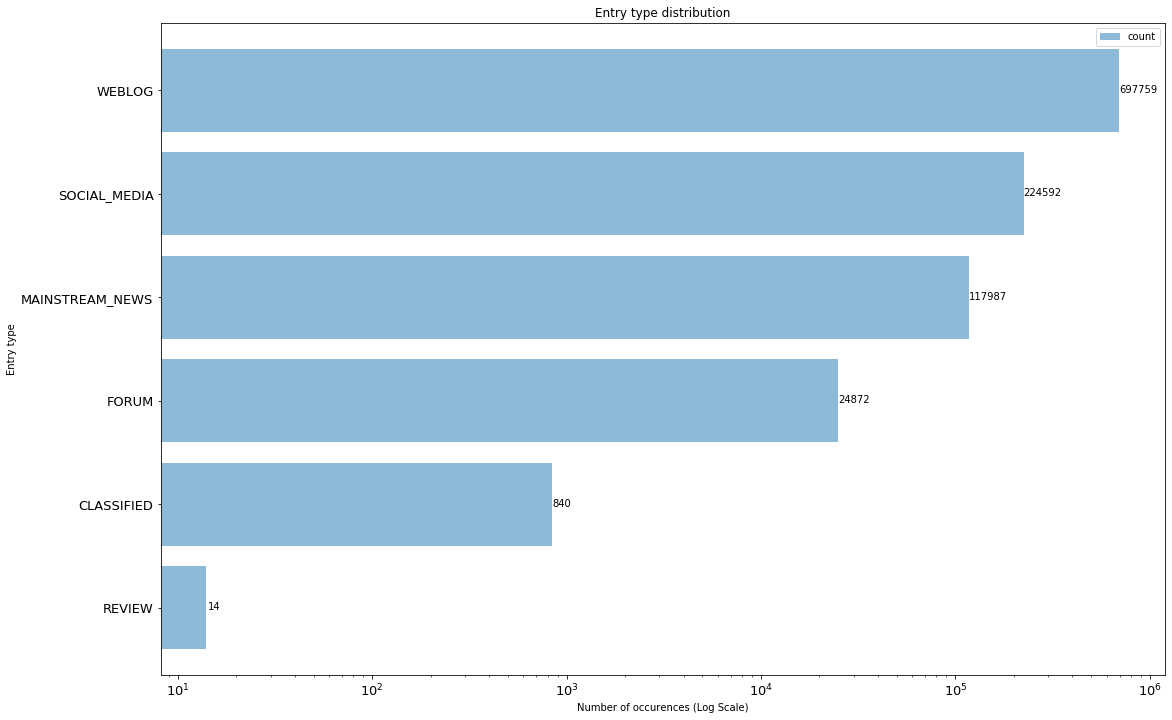

In [20]:
s = 0
pubType = filtered_entries.groupBy("publisherType").agg(count("*").alias("count")).orderBy("count").toPandas()
pubType.to_pickle("pubType_after_filter.pkl")
#pubType = pd.read_pickle("pubType_after_filter.pkl")
ax = pubType.plot(kind="barh", x="publisherType", y="count", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Entry type")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Entry type distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))
    s += i.get_width()

#### Language distribution for the Arab spring related entries

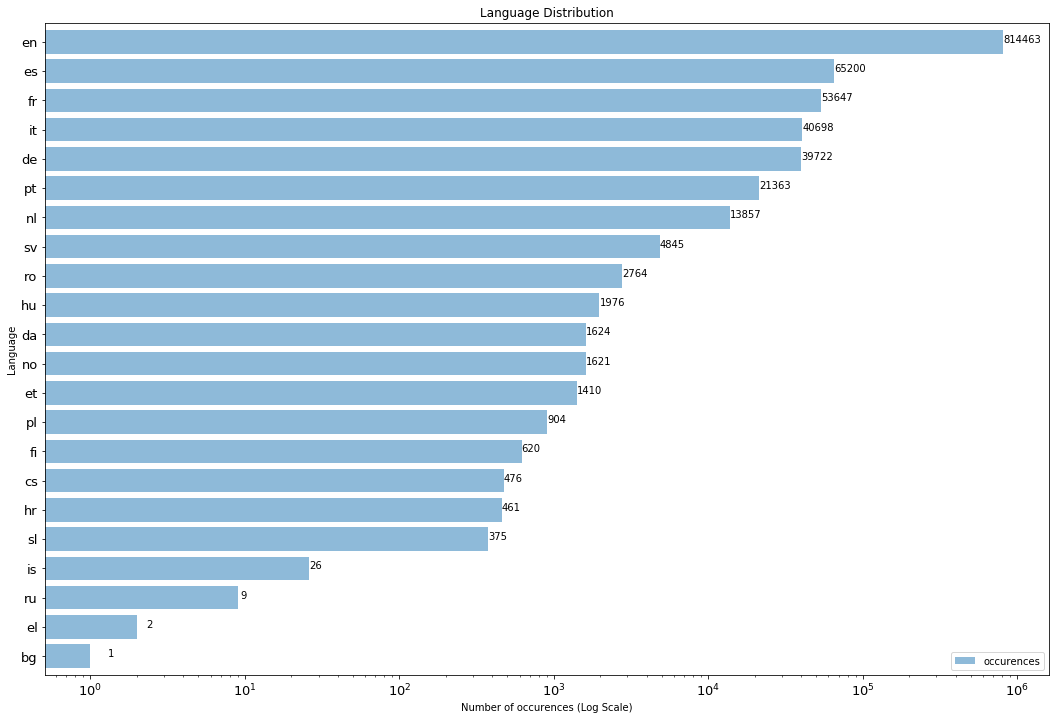

In [21]:
per_lang = filtered_entries.groupBy("language").agg(count("*").alias("occurences")).toPandas()
per_lang.to_pickle("AS_perLang.pkl")
#per_lang = pd.read_pickle("AS_perLang.pkl")
ax = per_lang.sort_values(by="occurences", ascending=True).plot(kind="barh", x="language", y="occurences", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Language")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Language Distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

We observe that we have a lot of missing languages, which is probably due to our small dataset (only 1.2 million entries over 380 millions) and the fact that some countries have a lot of their medias in english (such as Norway). We will need to find them with the urls and expand furthermore our dataset for the next milestone. 

We also notice no Arab entries, which is due to the arab grammar. Depending on where and what role in the sentence the word has, it will not be written the same way, which makes a keyword analysis almost impossible for non arab speakers. (which we are) 

#### Number of Arab Spring related entries per language and per day

/home/robin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 1080x360 with 0 Axes>

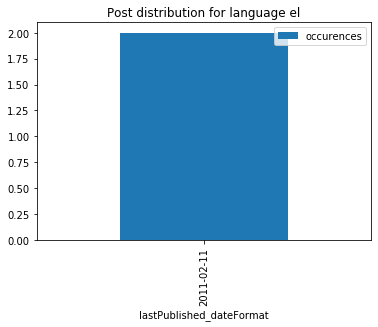

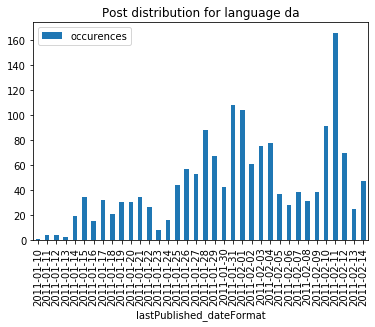

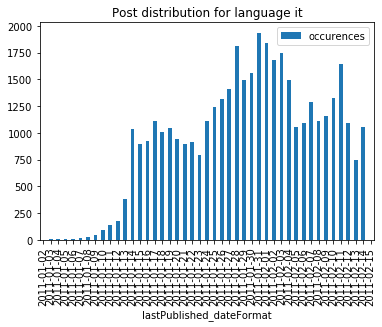

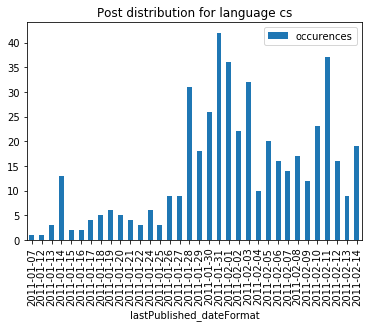

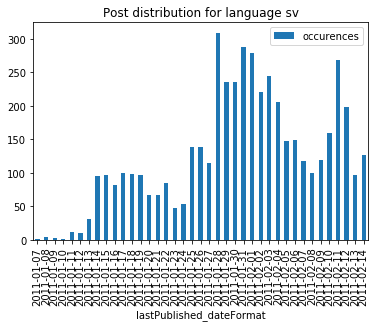

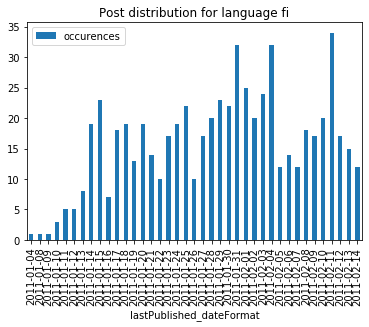

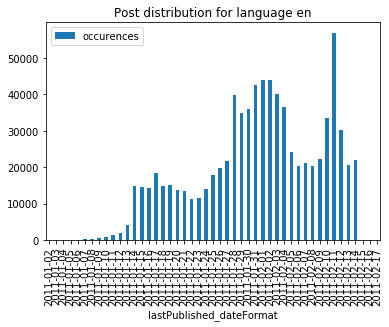

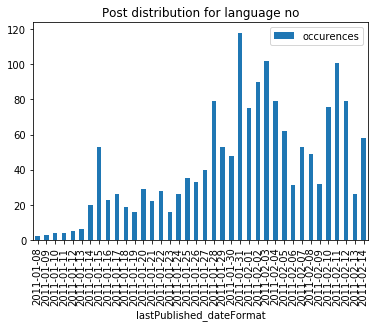

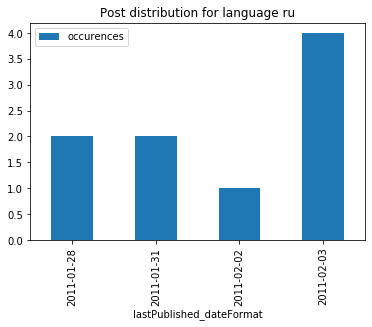

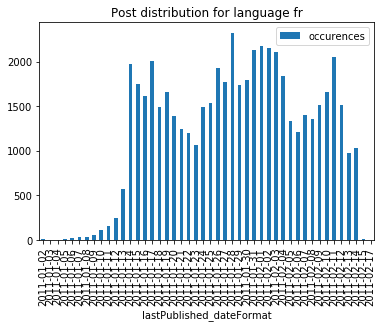

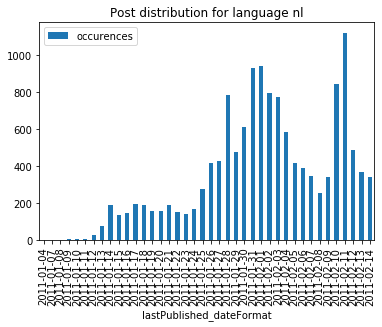

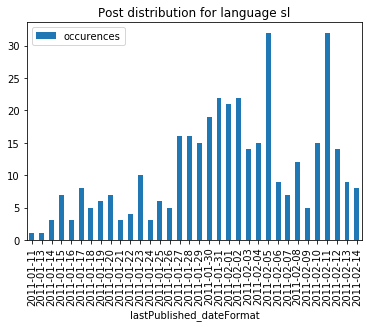

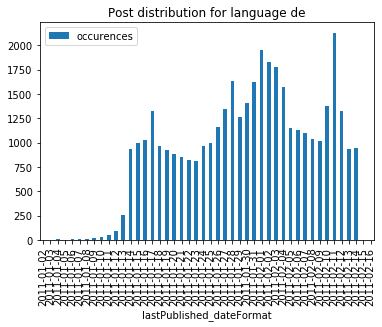

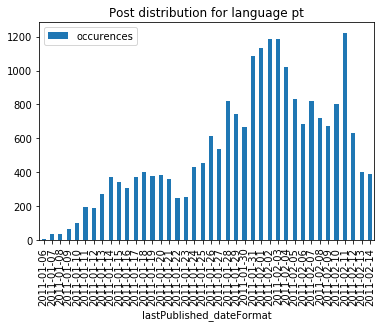

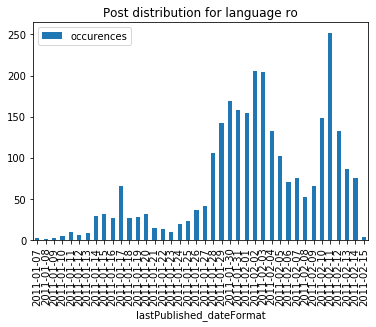

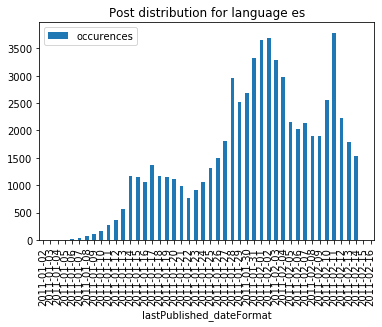

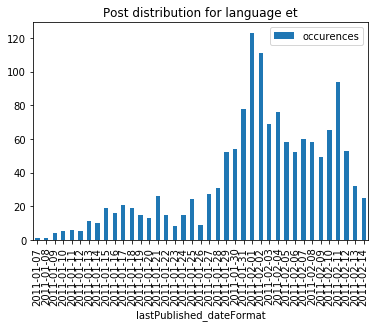

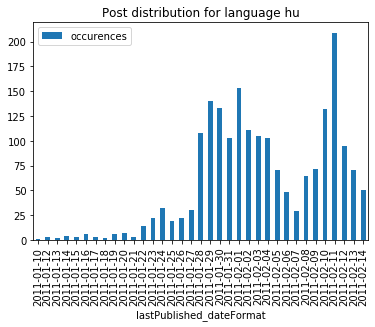

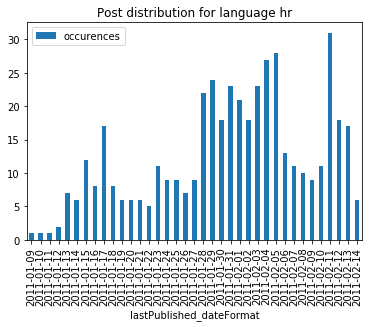

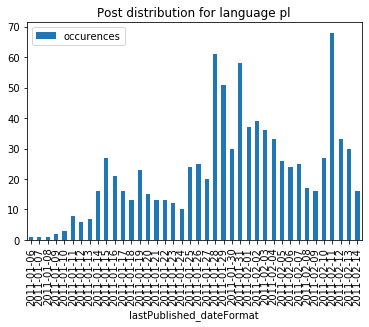

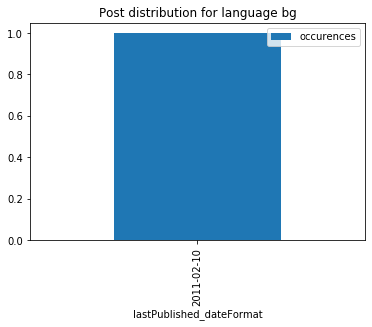

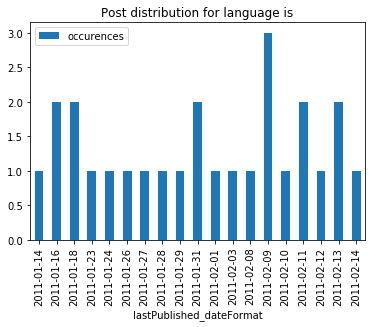

In [22]:
plt.figure(figsize = (15,5))
languages = list(set(occurences_per_lang_pd["language"]))
for l in languages:
    data_l = occurences_per_lang_pd[occurences_per_lang_pd["language"] == l].sort_values(by="lastPublished_dateFormat")
    ax = data_l.plot(kind="bar", x="lastPublished_dateFormat", y="occurences")
    plt.title("Post distribution for language " + l)

We observe that some languages have not enough data to be representative, such as the finnish plot which has only entries over one day. 

In [23]:
startDay = date(2010, 11, 5)

In [24]:
occurences_per_lang_pd["lastPublished_dateFormat"] = pd.to_datetime(occurences_per_lang_pd['lastPublished_dateFormat']).dt.date

In [25]:
arab_spring_events = {
    "2011-01-07": "Riots in Tunisia and Algeria",
    "2011-01-09": "Beginning of a referendum in South Sudan for autodetermination",
    "2011-01-10": "36 dead on the second day of the referendum in South Sudan",
    "2011-01-14": "Tunisian government overthrown",
    "2011-01-25": "Protestors gathered in Tahrir Square, Cairo, Egypt",
    "2011-01-27": "Start of the Yemenite revolution, and tunisia second governement formation",
    "2011-02-01": "Between 125 and 300 dead and 3000 wounded in a single day of protest in Egypt",
    "2011-02-11": "Egyptian president resigns",
    "2011-02-15": "Protests against the regime in Libya"
}

/home/robin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 734178.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


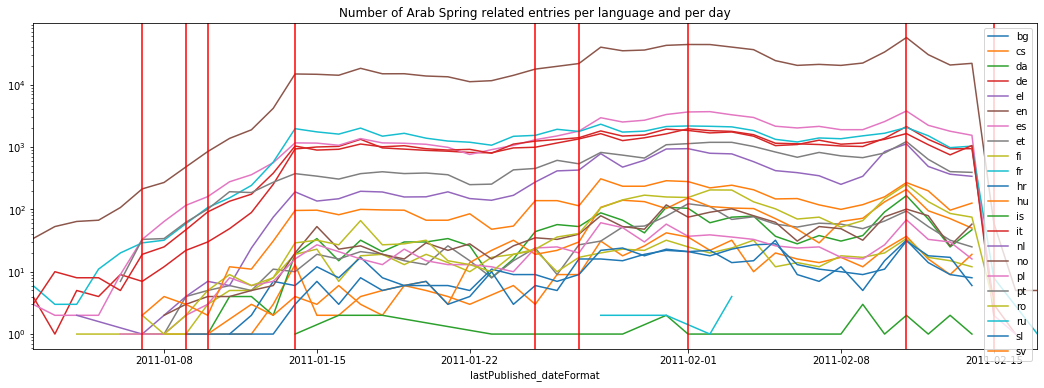

The red lines are (from left to rigth):
• Riots in Tunisia and Algeria,
• Referendum in South Sudan for autodetermination,
• 36 dead on the second day of the referendum in South Sudan, 
• Tunisian government overthrown, 
• Protestors gathered in Tahrir Square, Cairo, Egypt, 
• Start of the Yemenite revolution, and tunisia second governement formation 
• Between 125 and 300 dead and 3000 wounded in a single day of protest in Egypt 
• Egyptian president resigns 
• Protests against the regime in Libya


In [26]:
fig, ax = plt.subplots(figsize=(18,6))
for language, group in occurences_per_lang_pd.groupby("language"):
    group.plot(x="lastPublished_dateFormat", y="occurences", label=language, logy=True, ax=ax)

for event in arab_spring_events.keys():
    plt.axvline(x=datetime.strptime(event, "%Y-%m-%d").date(), color="red")
plt.title("Number of Arab Spring related entries per language and per day")
plt.show()


print("The red lines are (from left to rigth):"+
      "\n\u2022 Riots in Tunisia and Algeria,"+ 
      "\n\u2022 Referendum in South Sudan for autodetermination,"+
      "\n\u2022 36 dead on the second day of the referendum in South Sudan, "+
      "\n\u2022 Tunisian government overthrown, "+
      "\n\u2022 Protestors gathered in Tahrir Square, Cairo, Egypt, "+
      "\n\u2022 Start of the Yemenite revolution, and tunisia second governement formation "+
      "\n\u2022 Between 125 and 300 dead and 3000 wounded in a single day of protest in Egypt "+
      "\n\u2022 Egyptian president resigns "+
      "\n\u2022 Protests against the regime in Libya" )

The red lines represent major events related to the Arab Spring during this period.

#### Arab Spring related entries compared to non related ones

In [39]:
pubtype = pd.read_pickle("pubType_after_filter.pkl")
allType = pd.DataFrame()

In [40]:
allType["publisherType"]=['WEBLOG','SOCIAL_MEDIA','MAINSTREAM_NEWS','FORUM','CLASSIFIED','REVIEW',"MEME_TRACKER"]
allType["count"]= [133683918,231861650,1474494,5734378,517373,32773,2473]

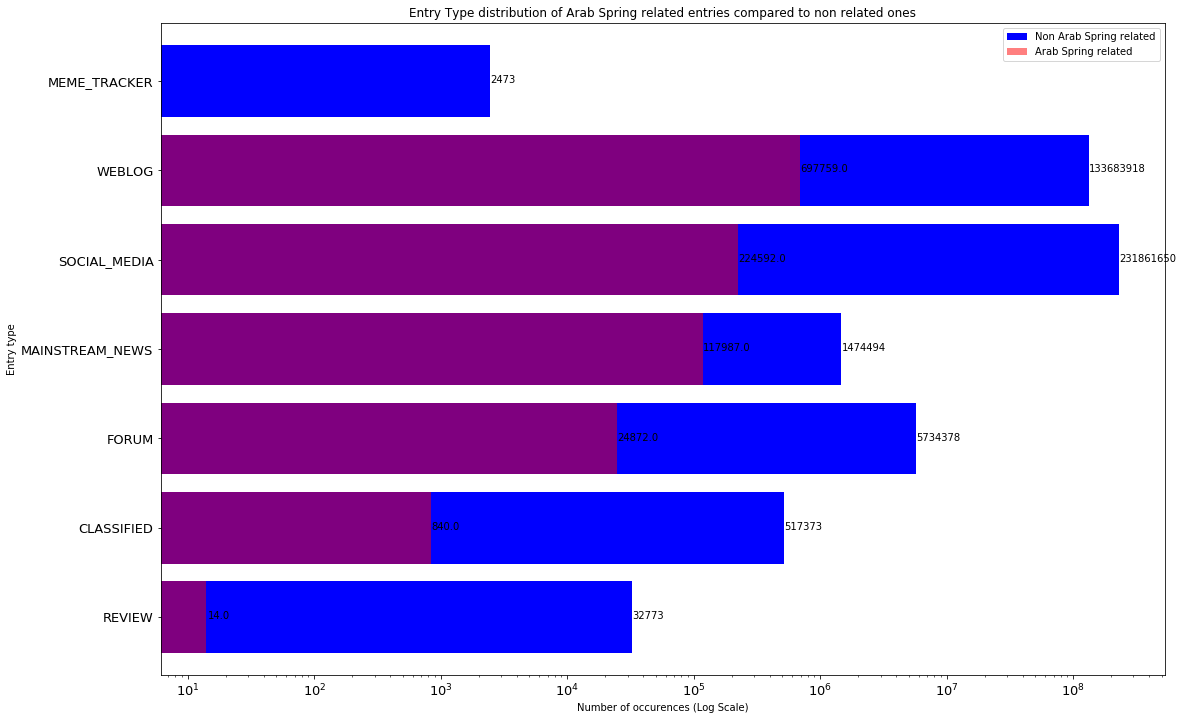

In [46]:
merged_df = allType.merge(pubType,on="publisherType",how = 'outer').sort_values('count_y')

fig = plt.figure()
ax = fig.add_subplot(111)
merged_df.plot(ax = ax,kind="barh", x="publisherType", y="count_x",color= 'blue',figsize=(18,12), logx=True, width=0.8, fontsize=13,label = "Total data")
merged_df.plot(ax= ax,kind="barh", x= "publisherType", y="count_y",color = 'red', alpha=0.5, logx=True, width=0.8, fontsize=13,label = "Arab Spring related")


ax.set_ylabel("Entry type")
ax.set_xlabel("Number of occurences (Log Scale)")
for i in ax.patches:
    if(i.get_width() != 0):
        ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

plt.title("Entry Type distribution of Arab Spring related entries compared to non related ones");

## Research question 1: infering main events

For each country, we'll have as keywords the capital,the country name, the adjective, and the name of the leader. We will be able to classify each entry as "this country" related. We allow an entry to be multiple countries related as an article can talk about multiple events occuring in different countries.

In [47]:
import csv


In [48]:
def read_singlelist(filename):
    results = []
    with open(filename, newline='') as inputfile:
        for row in csv.reader(inputfile):
            results.append(row[0])
    return [x.lower() for x in np.array(results).squeeze()]

In [49]:
key_algeria = [ "Algeria","Algiers","algerian","algerians","Bouteflika"]
key_egypt = ["Egypt","Cairo", "egyptians",'egyptian',"Mubarak"]
key_tunisia = ["Tunisia","Tunis","tunisian",'tunisians',"Ali"]
key_yemen = ["Yemen","Sanaa","yemenite","yemenites", "Saleh"]
key_syria = ["Syria","Damascus","syrian",'syrians',"Assad"]
key_lybia = ["Lybia","Tripoli","lybian","Gaddafi"]
key_bahrain = ["Bahrain","Manama","Bahraini","Khalifa"]
key_morocco = ["Morocco","Rabat","morrocan","morrocans","Mohammed"]
key_iraq = ["Iraq","Bagdad","iraqi"]
key_oman = ["Oman","omani","Saïd"]
key_saudi = ["Saudi","Arabia","saudi","Abdullah"]
key_jordan = ["Jordan","Amman","jordanian","Rifal"]
key_lebanon = ["Lebanon","lebanese","Beyrouth","Hariri"]
key_sudan = ["Sudan","sudanese","Karthoum","Bashir"]
key_djibouti = ['Djibouti','djiboutian',"Guelleh"]
key_kuwait = ["Kuwait","kuwaiti","Sabah"]

In [50]:
countries = ["Algeria","Egypt","Tunisia","Yemen","Syria","Lybia", \
             "Bahrain","Morocco","Iraq","Oman","Saudi","Jordan","Lebanon",\
            "Sudan","Djibouti","Kuwait"]
keys = {}
for country in countries:
    keys[country] =read_singlelist( \
                    "key_country/"+country+"translated_keywords.csv")
    
    

In [51]:
data = filtered_entries.toPandas()


In [52]:
from tqdm import tqdm

In [53]:
docs = {"Algeria": [], "Egypt": [], "Tunisia":[],"Yemen" : [], \
        "Syria": [], "Lybia":[], "Bahrain":[], "Morocco": [], \
        "Iraq":[], "Oman": [] , "Saudi": [], "Jordan": [], "Lebanon": [],\
       "Sudan": [], "Djibouti":[], "Kuwait":[]}

for entry in tqdm(range(len(data))):
    for country in keys:
        row =data.loc[entry]
        is_related = len(set(row["keywords"]) & set(keys[country])) > 0
        if(is_related):
            docs[country].append(row)


            

100%|██████████| 1066064/1066064 [33:18<00:00, 533.35it/s] 


In [54]:
for elem in docs:
    if (len(docs[elem])>1):
        print(elem)

Algeria
Egypt
Tunisia
Yemen
Syria
Lybia
Bahrain
Morocco
Iraq
Oman
Saudi
Jordan
Lebanon
Sudan
Djibouti
Kuwait


In [55]:
event_per_country = { "Algeria": {"2011-02-11":"Bouteflika resigns"}, "Egypt": \
                          {"2011-01-25": "Start of the revolution","2011-02-11": "Mubarak resigns"},\
                          "Tunisia": {"2011-01-14": "Tunisian government disolved and Ben Ali's escape","2011-01-27":"Creation of a new government"}, \
                          "Yemen": {"2011-01-27": "Start of the revolution","2011-02-02":"President announces he will not run again for presidency, and will not pass power to his son"}, \
                          "Syria": {"2011-02-03":"Call for a day of rage on social medias"},\
                          "Bahrain": {"2011-02-14":"Start of the revolution"},\
                          "Morocco": {},\
                          "Lybia": {},\
                          "Iraq": {"2011-02-12": "Start of the protests"},\
                          "Oman" : {"2011-01-17":"Start of the protests"},\
                          "Saudi": {"2011-01-15": "Ben ALi seeks refuge in Saudi Arabia ","2011-01-16":"70000 attneded to a protestor's funeral (killed by the police)"},\
                          "Jordan": {"2011-01-14":"Start of the protests","2011-02-01":"Government fired by king"},\
                          "Lebanon": {"2011-01-13":"Collapse of the government","2011-01-24": "Protests againts the Hezbollah"},\
                          "Sudan": {"2011-01-30": "Start of the protests"},\
                          "Djibouti": {"2011-01-25": "Start of the protests"},\
                          "Kuwait": {"2011-01-18":"Start of the protests"}}

In [56]:
for country in docs:
    if(len(docs[country])>0):
        docs[country] = pd.concat(docs[country], axis =1).transpose()[['title','lastPublished_dateFormat']] \
        .groupby("lastPublished_dateFormat").agg(len)
    

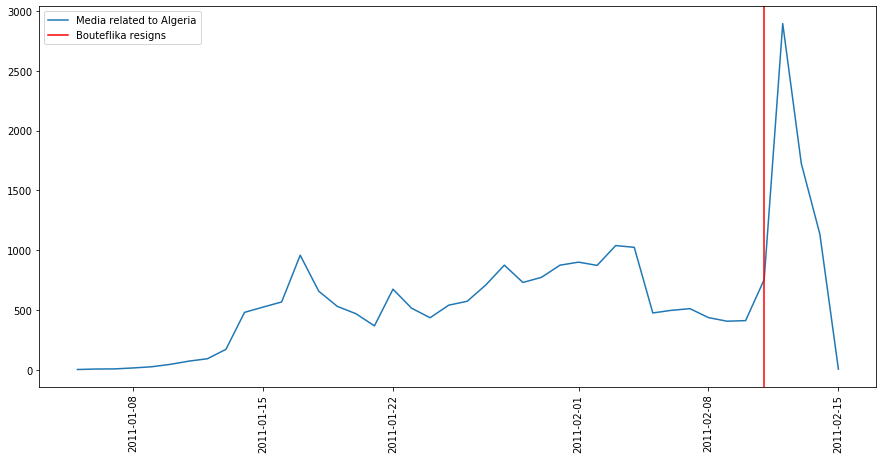

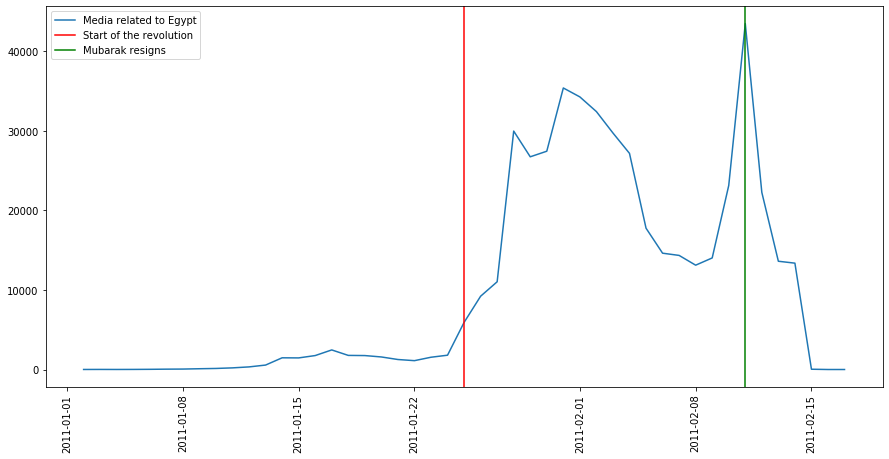

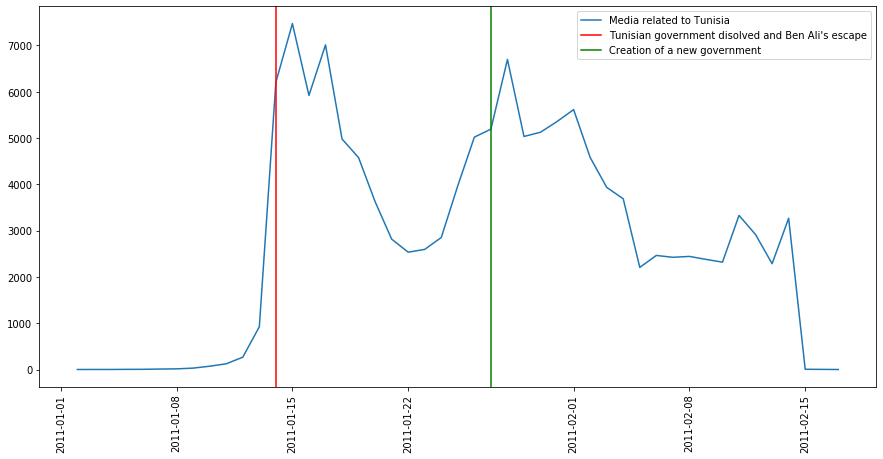

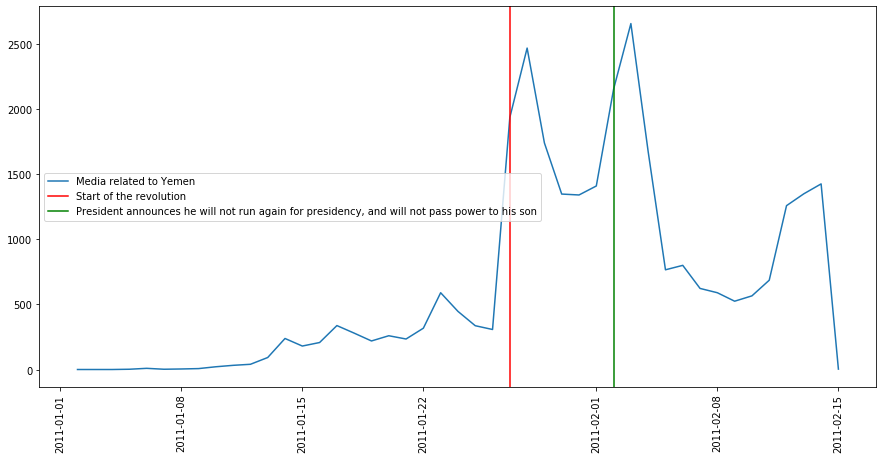

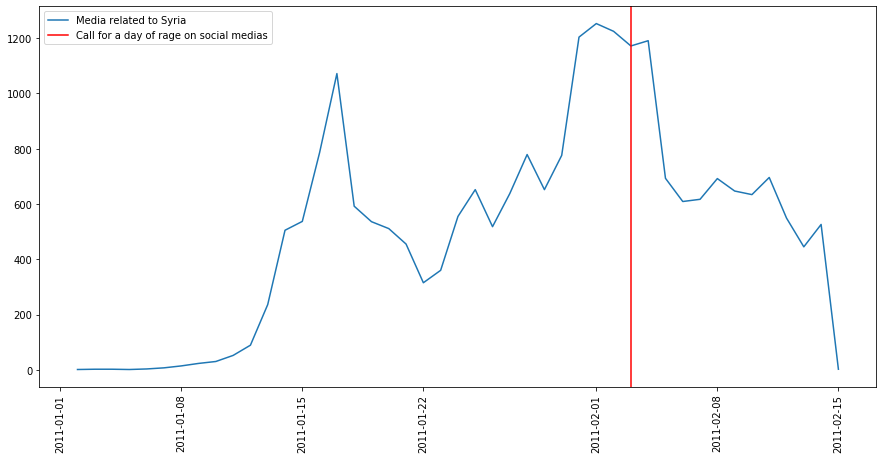

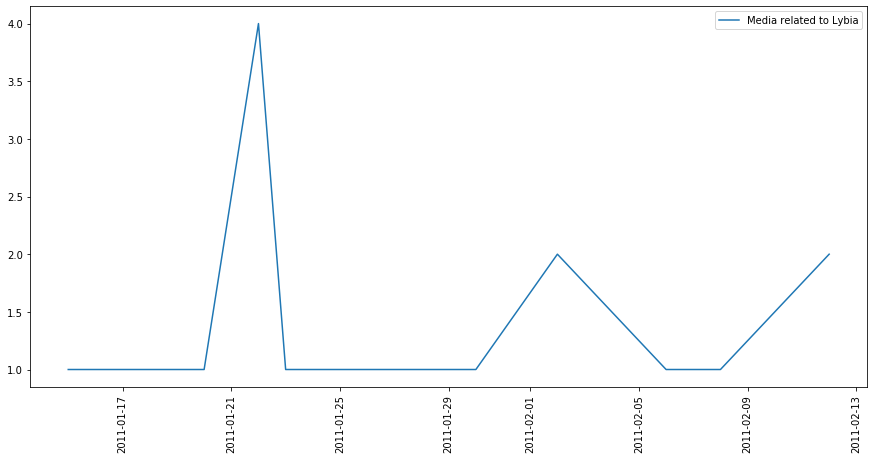

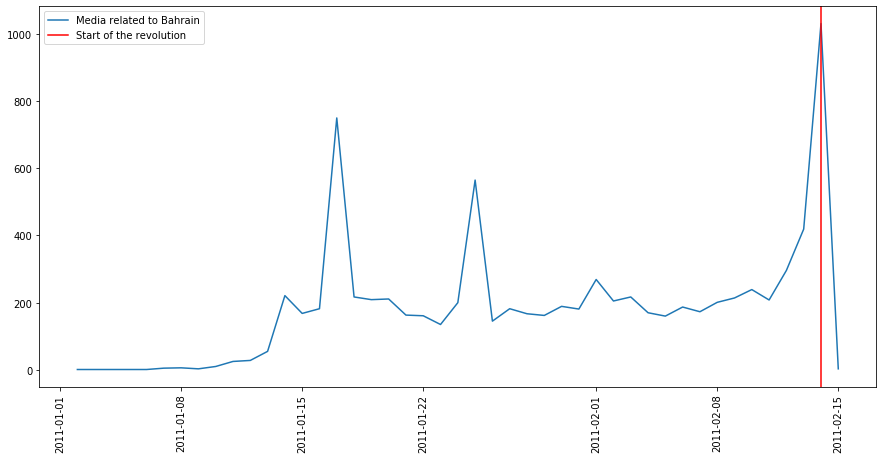

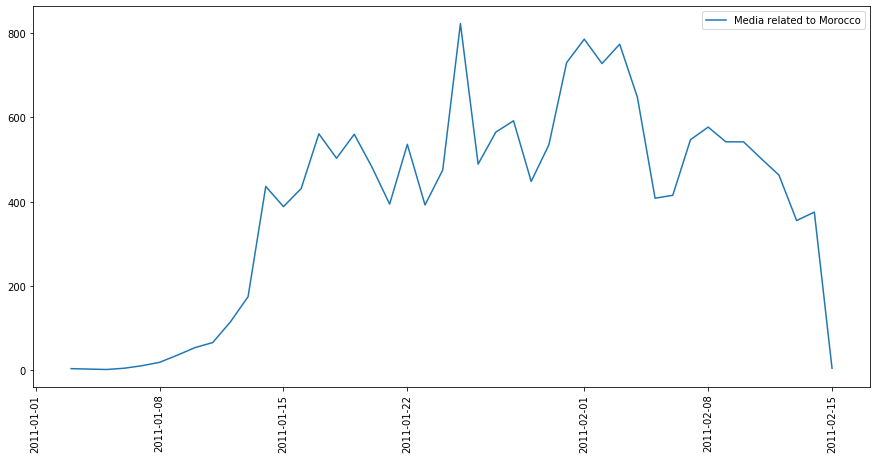

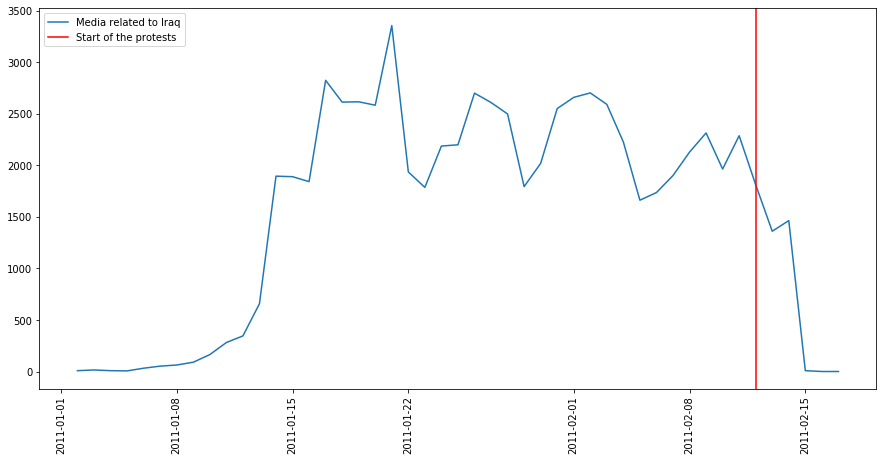

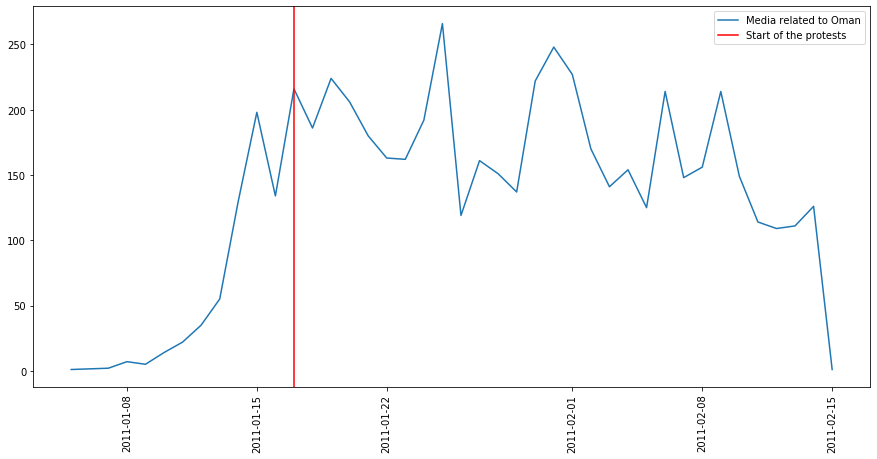

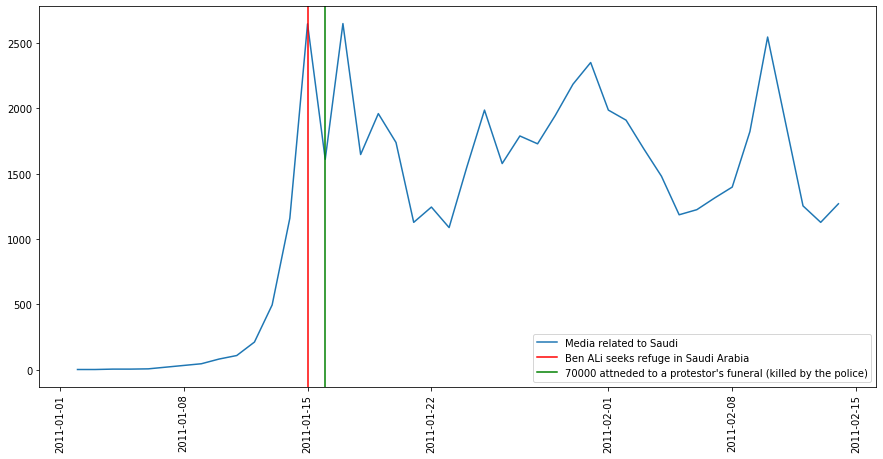

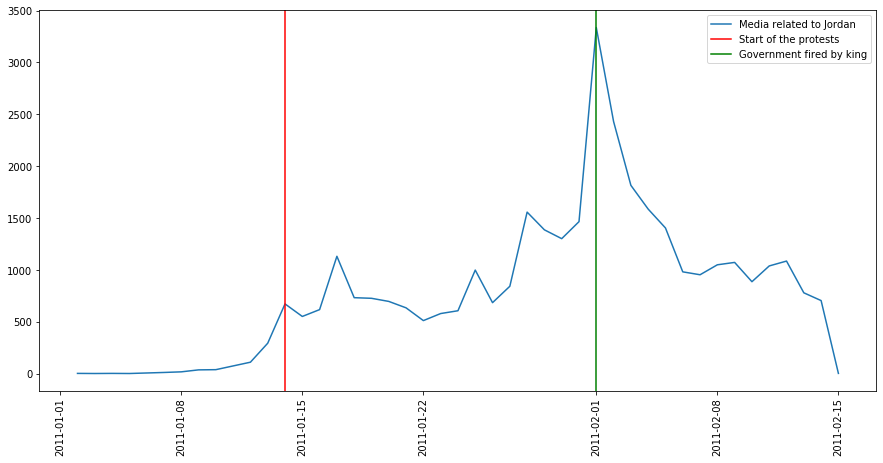

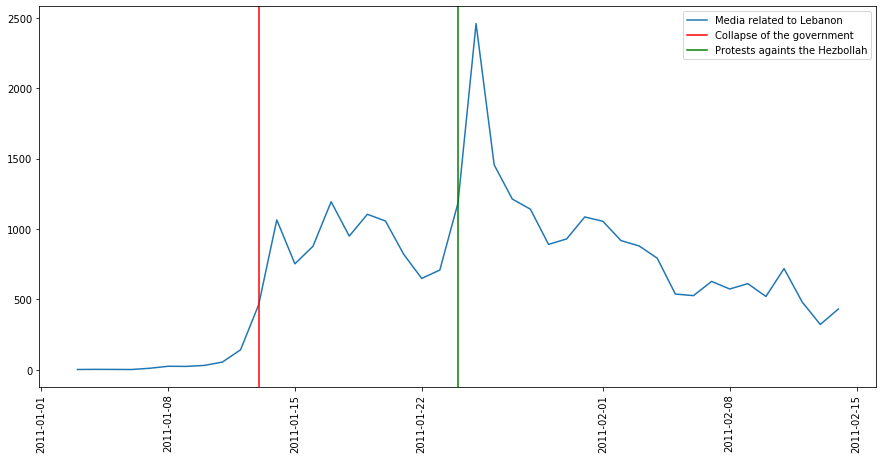

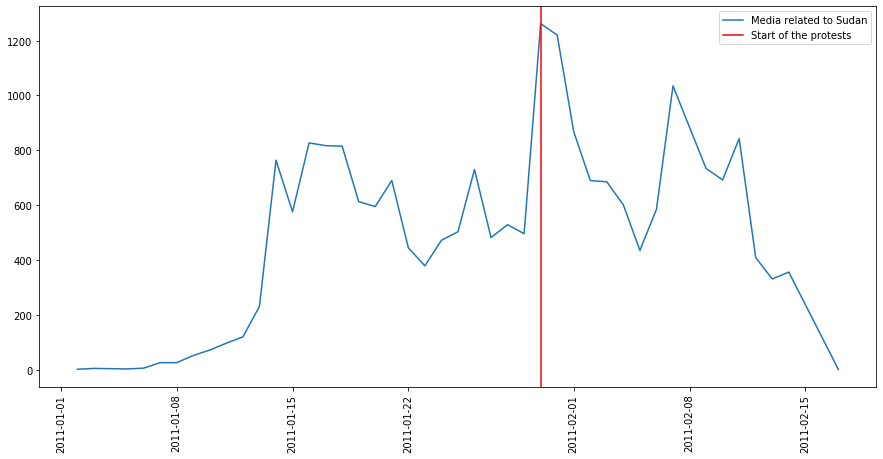

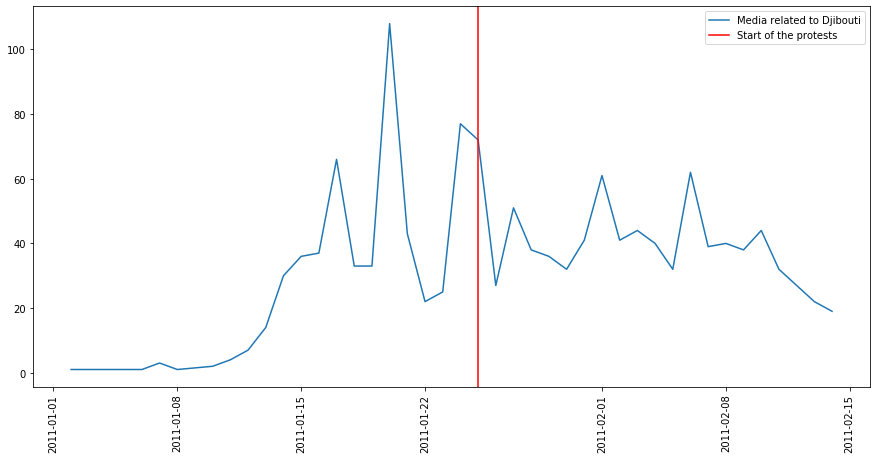

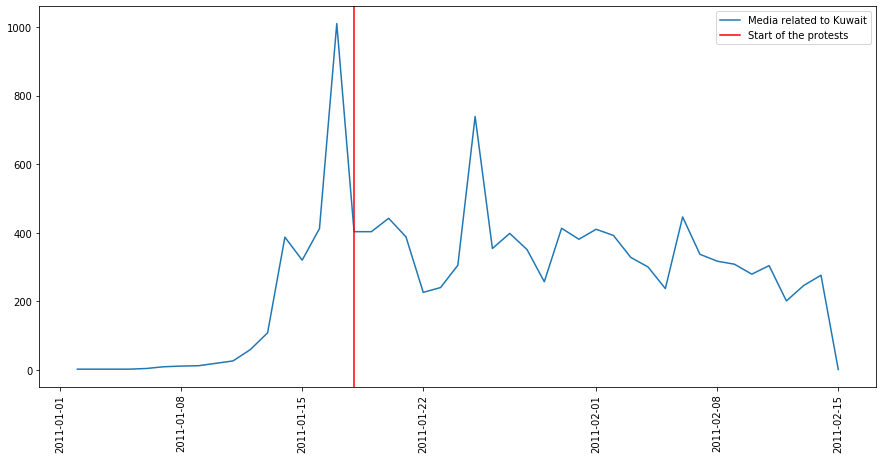

In [57]:
for elem in docs:
    if(len(docs[elem])>0):
        #ax = docs[elem].plot(rot = 45)
        plt.figure(figsize =(15,7))
        plt.plot(docs[elem])
        events = event_per_country[elem]
        it= 0
        for event in events:
            if(it == 0):
                color = "red"
                it +=1
            else : color = "green"
            plt.axvline(x=event,color = color)
        
        plt.xticks(rotation=90)
        plt.legend(["Media related to {}".format(elem)]+ list(events.values()))
        plt.show()
     

## Research question2 :Hyperlink network analysis


**Preprocessing Fetching content:**  

To analyse how the differents websites are reference on internet, we will extract the hyperlink present into the content that reference other websites and pages. 
The first part is to extract the websitefrom the URL post to get the website then inside the content we fetch and save into a list the different pages/website associated.

In [58]:
import pickle
import csv
import pandas as pd
from langdetect import detect
from bs4 import BeautifulSoup
import wikipedia
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import numpy as np
import string
from numpy.linalg import norm
import os
import matplotlib.pyplot as plt
from googletrans import Translator
import seaborn as sns
sns.set(style="darkgrid")
import pyspark
import pyspark.sql
from pyspark.sql import *
#from pyspark.sql.functions import *
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_extract, col, udf, lit, size, unix_timestamp, from_unixtime, explode, concat
import re
import networkx as nx
import datetime
import matplotlib as mpl
from functools import reduce  

In [71]:
feed_entries = spark.read.json("data/spinn3r_content.json")
feed_entries = feed_entries.drop("keywords").drop( "title").dropDuplicates()

In [72]:
# Regular expression for a page and a website
re_page = "(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)"
re_website = "(https?:\/\/?(www\.)?(([a-zA-Z0-9]+(-?[a-zA-Z0-9])*\.)*)+[\w]{2,})"

flatten = lambda l: [item for sublist in l for item in sublist]

def regexp_extract_all(text, regex):
    all_matches = re.findall(regex, text)
    return list(filter(None,flatten(all_matches)))
    

def add_website(data, re_website):
    data = data.withColumn("website", regexp_extract(data.url, re_website, 0))
    return data

def extract_webstite_from_content(data):
    
    def regexp_extract_all(text, regex):
        
        all_matches = re.findall(regex, text)
        return list(filter(None,flatten(all_matches)))
    
    extract_udf = udf(regexp_extract_all, ArrayType(StringType()))
    data = data.withColumn("websitesFetch", extract_udf(data.cleaned_content, lit(re_website)))
    return data

def extract_pages_from_content(data):
    
    def regexp_extract_all(text, regex):
        all_matches = re.findall(regex, text)
        return all_matches

    extract_udf = udf(regexp_extract_all, ArrayType(StringType()))
    data = data.withColumn("pagesFetch", extract_udf(data.cleaned_content, lit(re_page)))
    return data

In [73]:
# Extract the website from the url
feed_entries_test = feed_entries.sample(0.1)

feed_entries_test = add_website(feed_entries_test, re_website)

# Extract pages from the content
feed_entries_test = extract_pages_from_content(feed_entries_test)

#Extract websites from content
feed_entries_test = extract_webstite_from_content(feed_entries_test)



In [79]:
feed_entries_test = feed_entries_test.withColumn("nbr_pages", size("pagesFetch")).sort(col("nbr_pages").desc())
feed_entries_test = feed_entries_test.withColumn("nbr_websites", size("pagesFetch")).sort(col("nbr_websites").desc())
feed_entries_stats = feed_entries_test

In [80]:
count_websites_linked = feed_entries_test.groupby('website').agg(f.count('website').alias('count'))
count_websites_linked.select("*").sort(col('count').desc()).show()

+--------------------+-----+
|             website|count|
+--------------------+-----+
| http://facebook.com|23590|
|http://www.panora...| 4932|
|http://www.mouths...| 1468|
|http://www.tvshow...| 1104|
|http://article.wn...|  990|
|http://feeds.midd...|  939|
|http://www.gigjun...|  875|
|http://us.rd.yaho...|  814|
|http://www.facebo...|  645|
|http://da.feedspo...|  624|
|http://feeds.cair...|  570|
|http://www.guardi...|  557|
|http://feeds.egyp...|  523|
|http://www.myspac...|  506|
|http://pornstartw...|  467|
|http://altgirltwe...|  432|
|http://fr.news.ya...|  382|
|http://www.umlaut...|  381|
|http://www.axessc...|  359|
|http://www.signon...|  355|
+--------------------+-----+
only showing top 20 rows



**Graph creation:**

To extract important information we decide to create several graphs depending on the entries (nodes and edges):
    - page-page graph over datetime
    - page-page graph over post type
    - website-website graph over post type

From the lastPublished date-format field , we count the number of days starting from the 1st January. Count the number of days shoxw which URL was reference before others. 

In [81]:
def datetime_transform(entries):
    #Transform the lastPublished date into a timestamp.
    
    entries = entries.withColumn("lastPublished_dateFormat", col("lastPublished").substr(0, 10))
    entries = entries.withColumn("timestamp", from_unixtime(unix_timestamp('lastPublished_dateFormat', 'yyyy-MM-dd')))
    #sort by datetime: some of the articles are past events to clean
    #feed_entries_test2.select(["url", "website", "lastPublished", "timestamp"]).sort(col("timestamp").desc()).show(500)

    #Count the number of days since the first post: "2011-01-02 00:00:00"
    ref_datetime = datetime.datetime.strptime("2011-01-02 00:00:00", '%Y-%m-%d %H:%M:%S')
       
    def count_days(data):
        def substract_datetime(ref_timestamp, timestamp):

            ref_datetime = datetime.datetime.strptime(ref_timestamp, '%Y-%m-%d %H:%M:%S').date()
            if timestamp== None:
                nbr_days = 50
            else:
                datetime_data = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').date()
                nbr_days = (datetime_data - ref_datetime).days
                if nbr_days <0:
                    nbr_days = 0


            return nbr_days

        get_days = udf(substract_datetime, IntegerType())
        data = data.withColumn("days_count", get_days(lit("2011-01-02 00:00:00"), entries.timestamp))
        return data
    
    #Apply the function
    entries = count_days(entries)
    return entries


In [115]:
feed_entries_test2 = datetime_transform(feed_entries_test).sample(0.035).collect()
feed_entries_test2 = spark.createDataFrame(feed_entries_test2)


In [116]:
interested_cols = ["days_count", "url", "pagesFetch", "nbr_pages"]
def get_graph_params_datetime(data):
    print(data.count())
    edges_entries = data.withColumn("nodes", explode("pagesFetch"))
    
    nodes_entries = edges_entries.select(col("nodes").alias("url")).withColumn("days_count", lit(0)).withColumn ("nbr_pages", lit(1))
    
    nodes_entries = edges_entries.select(["url", "days_count", "nbr_pages"]).union(nodes_entries).dropDuplicates(["url"])
    #size_nodes = edges_entries.select("nbr_pages")
    
    print(nodes_entries.count())

    edges_entries = edges_entries.toPandas()
    nodes_entries = nodes_entries.toPandas()

   # display(edges_entries.head())
    
    nodes = nodes_entries.url.tolist()
    days = nodes_entries.days_count.tolist()
    size_nodes = nodes_entries.nbr_pages.tolist()
    
    edges_entries["edges"] = list(zip(edges_entries.url, edges_entries.nodes ))
    edges = list(set(edges_entries["edges"].tolist()))

    days = [float(i) for i in days]
    print(len(edges), len(nodes), len(days), len(size_nodes))
    return edges, nodes, days, size_nodes

edges, nodes, days, size_nodes = get_graph_params_datetime(feed_entries_test2.select(interested_cols))


5526
2612
2078 2612 2612 2612


In [120]:
def create_draw_graph(nodes_, edges_, node_repartition, size_nodes,title):
    G = nx.DiGraph()

    #G.add_nodes_from(nodes_)
    G.add_edges_from(edges_)
    
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.layout.spring_layout(G)

    size_nodes = [x *10 for x in size_nodes]
    M = G.number_of_edges()
    print(G.number_of_nodes(), len(node_repartition))
    edge_colors = range(2, M + 2)
    nodes_colors = node_repartition
    
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=size_nodes, node_color=nodes_colors, node_cmap=plt.get_cmap("plasma"), width=2)
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='->',
                                   arrowsize=10, edge_color=edge_colors,
                                   edge_cmap=plt.cm.Blues, width=2)


    pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.get_cmap("plasma"),label="Time since 1st of january")
    pc.set_array(nodes_colors)
    plt.colorbar(pc)


    ax = plt.gca()
    ax.set_axis_off()
    plt.title(title)
    plt.show()

2612 2612


/home/robin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/robin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/robin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/robin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_

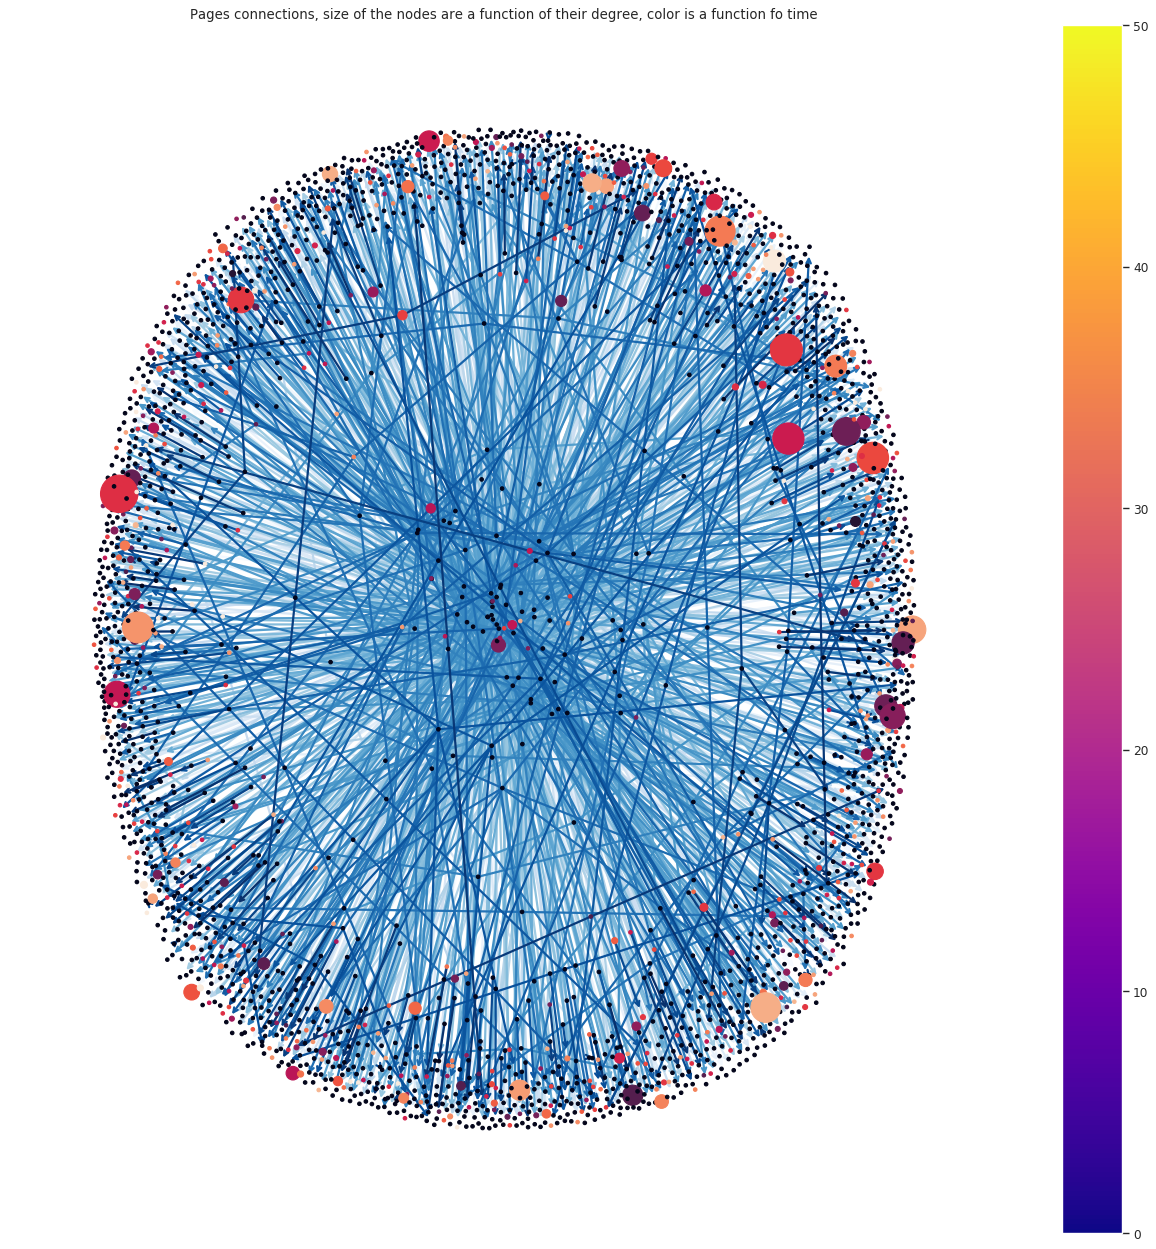

In [121]:
create_draw_graph(nodes, edges, days,size_nodes,"Pages connections, size of the nodes are a function of their degree, color is a function fo time")

In [123]:
interested_cols = ["publisherType", "url", "pagesFetch", "nbr_pages"]

def get_graph_params_post(data):
    print(data.count())
    data.groupby("publisherType").agg(f.count("publisherType")).show()

    
    edges_entries = data.withColumn("nodes", explode("pagesFetch"))
    
    nodes_entries = edges_entries.select(col("nodes").alias("url")).withColumn("publisherType", lit("UNKNOWN")).withColumn ("nbr_pages", lit(1))
    nodes_entries = edges_entries.select(["url", "publisherType", "nbr_pages"]).union(nodes_entries).dropDuplicates(["url"])
    print(nodes_entries.count())
    nodes_entries.groupby("publisherType").agg(f.count("publisherType")).show()



    edges_entries = edges_entries.toPandas()
    nodes_entries = nodes_entries.toPandas()
    
   # display(edges_entries.head())
    
    nodes = nodes_entries.url.tolist()
    size_nodes = nodes_entries.nbr_pages.tolist()

    posts_type = nodes_entries.publisherType.tolist()
    map_ = {'CLASSIFIED': 4. ,"FORUM": 3., "UNKNOWN": 5., "SOCIAL_MEDIA": 2., "WEBLOG": 1., "MAINSTREAM_NEWS": 0.}
    posts_type = [float(map_[s]) for s in posts_type]
    
    edges_entries["edges"] = list(zip(edges_entries.url, edges_entries.nodes ))
    edges = list(set(edges_entries["edges"].tolist()))

    print(len(edges), len(nodes), len(posts_type))
    return edges, nodes, posts_type, size_nodes

edges, nodes, posts_type, size_nodes = get_graph_params_post(feed_entries_test2.select(interested_cols))

5526
+---------------+--------------------+
|  publisherType|count(publisherType)|
+---------------+--------------------+
|     CLASSIFIED|                   1|
|         WEBLOG|                3916|
|MAINSTREAM_NEWS|                 601|
|   SOCIAL_MEDIA|                 899|
|          FORUM|                 109|
+---------------+--------------------+

2612
+---------------+--------------------+
|  publisherType|count(publisherType)|
+---------------+--------------------+
|         WEBLOG|                 387|
|MAINSTREAM_NEWS|                   6|
|        UNKNOWN|                2050|
|   SOCIAL_MEDIA|                 141|
|          FORUM|                  28|
+---------------+--------------------+

2078 2612 2612


2612 2612


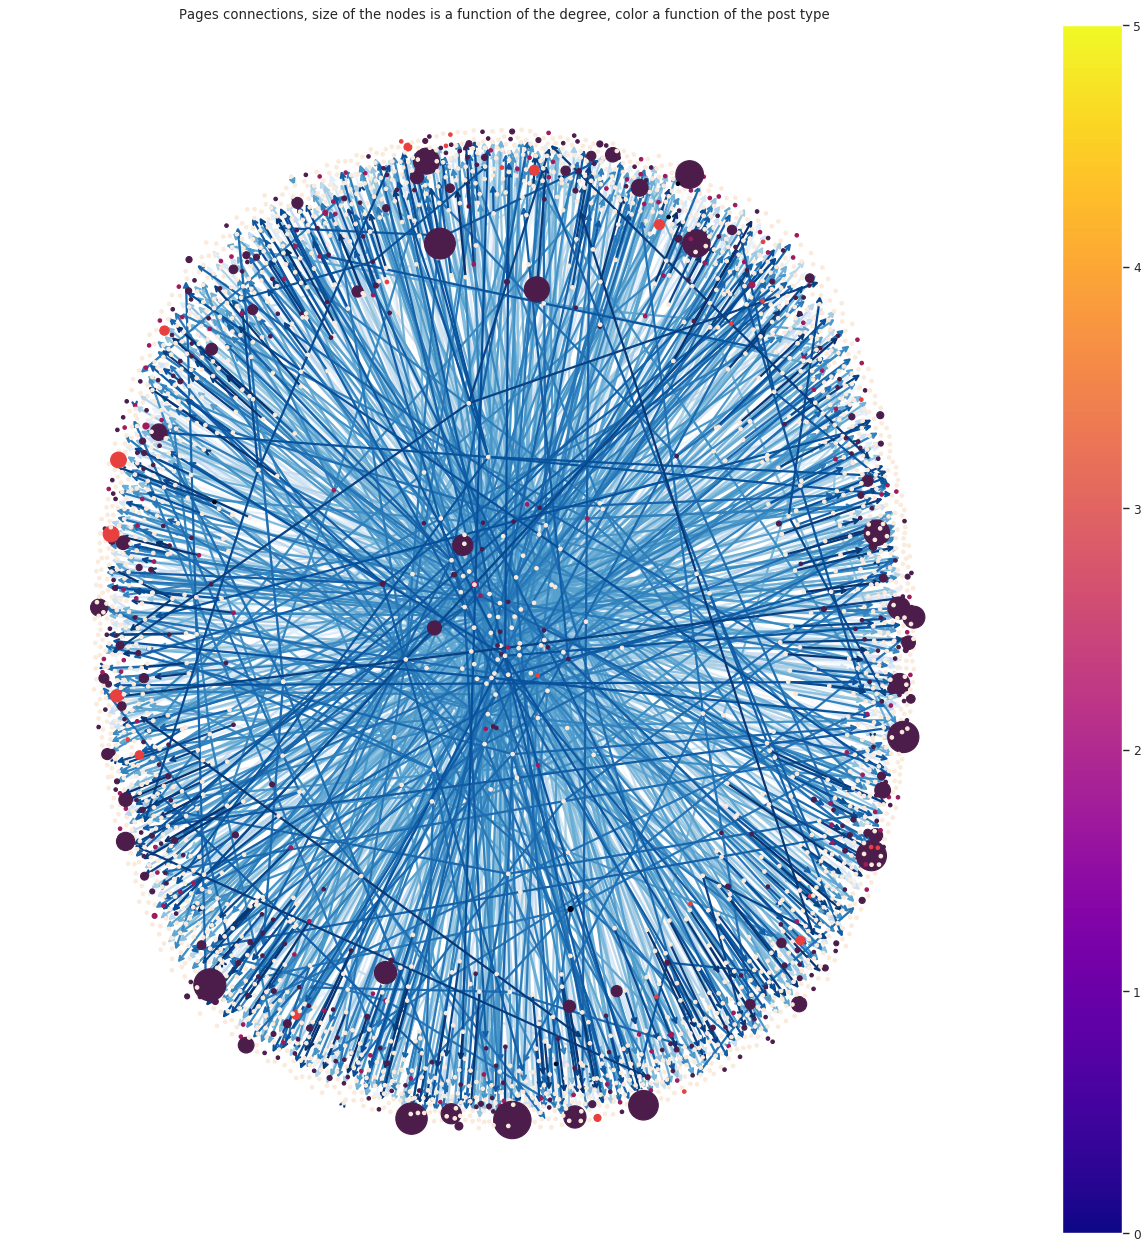

In [125]:
create_draw_graph(nodes, edges, posts_type,size_nodes, 'Pages connections, size of the nodes is a function of the degree, color a function of the post type')

On the graph above, the nodes' colors are as such:
* Unknown: yellow/white
* Weblog: dark purple/black
* Social Media: light purple
* Forum: red
* Classified: orange
* Mainstream news: 

In [127]:
interested_cols = ["publisherType", "website", "websitesFetch", "nbr_websites"]

def get_graph_params_post(data):
    print(data.count())
    
    edges_entries = data.withColumn("nodes", explode("websitesFetch"))
    
    nodes_entries = edges_entries.select(col("nodes").alias("url")).withColumn("publisherType", lit("UNKNOWN")).withColumn("nbr_websites", lit(1))
    nodes_entries = edges_entries.select(["website", "publisherType", "nbr_websites"]).union(nodes_entries).dropDuplicates(["website"])
    print(nodes_entries.count())
    nodes_entries.groupby("publisherType").agg(f.count("publisherType")).show()

    edges_entries = edges_entries.toPandas()
    nodes_entries = nodes_entries.toPandas()
    
   # display(edges_entries.head())
    
    nodes = nodes_entries.website.tolist()
    size_nodes = nodes_entries.nbr_websites.tolist()
    map_ = {'CLASSIFIED': 4. ,"FORUM": 3., "UNKNOWN": 5., "SOCIAL_MEDIA": 2., "WEBLOG": 1., "MAINSTREAM_NEWS": 0.}

    posts_type = nodes_entries.publisherType.tolist()
    posts_type = [float(map_[s]) for s in posts_type]
    
    edges_entries["edges"] = list(zip(edges_entries.website, edges_entries.nodes ))
    edges = list(set(edges_entries["edges"].tolist()))

    print(len(edges), len(nodes), len(posts_type))
    return edges, nodes, posts_type, size_nodes

edges, nodes, posts_type, size_nodes = get_graph_params_post(feed_entries_test2.select(interested_cols))

5526
1990
+---------------+--------------------+
|  publisherType|count(publisherType)|
+---------------+--------------------+
|         WEBLOG|                 338|
|MAINSTREAM_NEWS|                   4|
|        UNKNOWN|                1603|
|   SOCIAL_MEDIA|                  19|
|          FORUM|                  26|
+---------------+--------------------+

2403 1990 1990


1990 1990


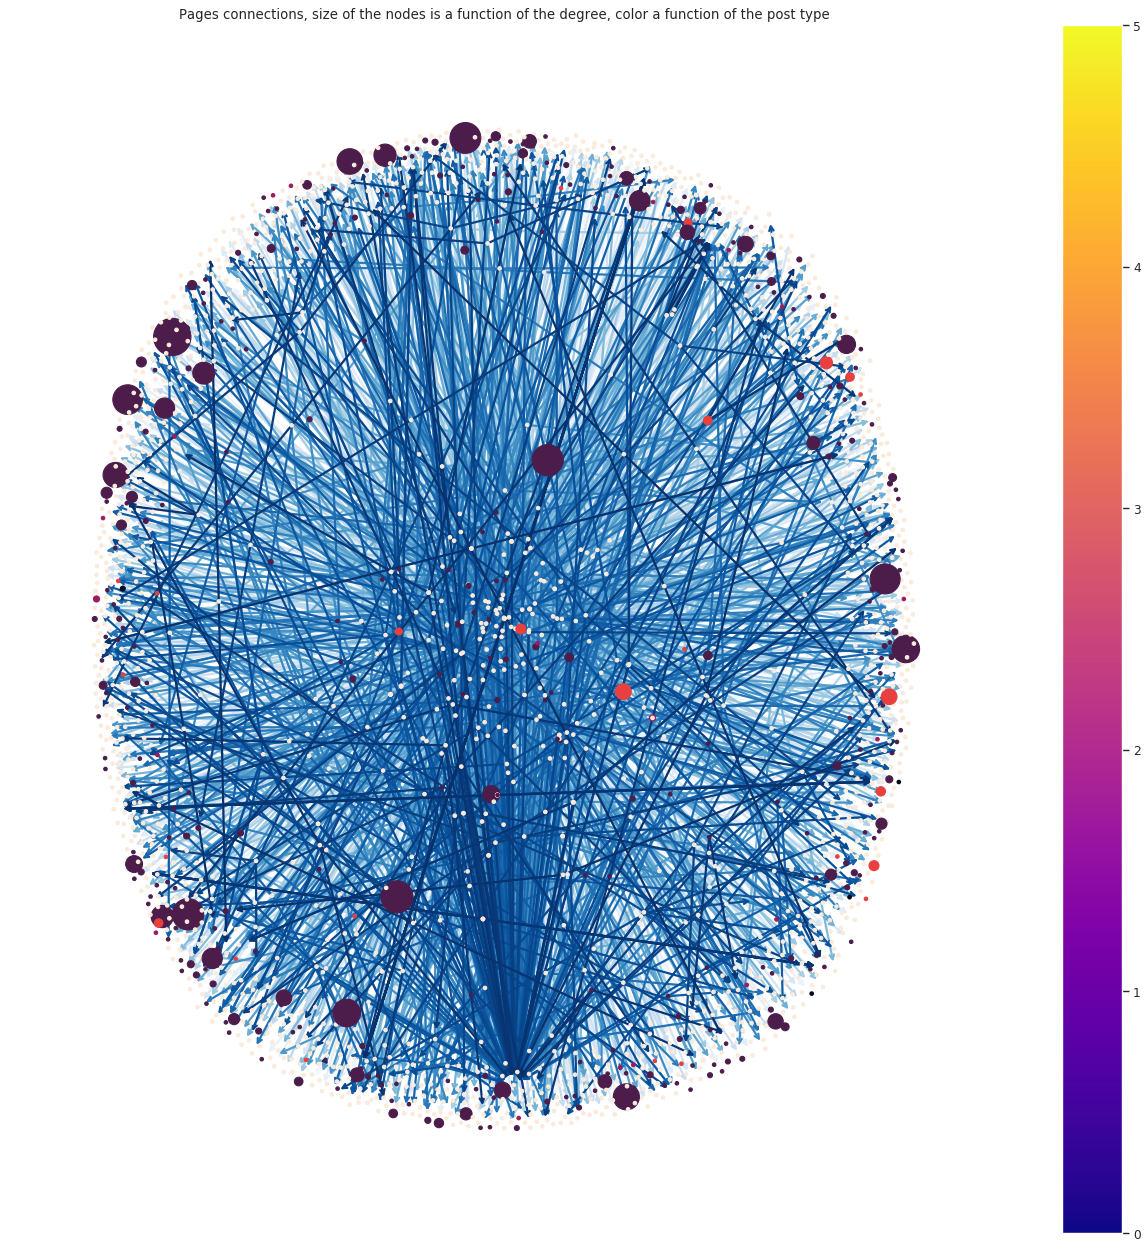

In [129]:
create_draw_graph(nodes, edges, posts_type,size_nodes,'Pages connections, size of the nodes is a function of the degree, color a function of the post type')

On the graph above, the nodes' colors are as such:
* Unknown: yellow/white
* Weblog: dark purple/black
* Social Media: light purple
* Forum: red
* Classified: orange
* Mainstream news: 

In [112]:
feed_entries_test2.select(["website", "nbr_pages", "publisherType"]).show(20, False)

+----------------------------------+---------+-------------+
|website                           |nbr_pages|publisherType|
+----------------------------------+---------+-------------+
|http://ayakkabiciniz.blogspot.com |1669     |WEBLOG       |
|http://lacomunidad.elpais.com     |293      |WEBLOG       |
|http://aion-guides.de             |192      |WEBLOG       |
|http://staringfrog.com            |146      |WEBLOG       |
|http://aion-guides.de             |144      |WEBLOG       |
|http://twidw.doctorwhonews.net    |100      |WEBLOG       |
|http://aion-guides.de             |96       |WEBLOG       |
|http://puqee.com                  |87       |FORUM        |
|http://www.wyfopedia.org.uk       |86       |WEBLOG       |
|http://naturgarten.dirndlwiki.at  |83       |WEBLOG       |
|http://charlottemusic.typepad.com |80       |WEBLOG       |
|http://monitor.creativecommons.org|60       |WEBLOG       |
|http://cdndailydigest.blogspot.com|55       |WEBLOG       |
|http://wiki.showmedo.co

In [131]:
tot_count = feed_entries_test2.select("*").count()
one_zero_link_count = feed_entries_test2.select(["website", "nbr_pages", "publisherType"]).filter(feed_entries_test2["nbr_pages"] < 2).count()
zero_link_count  = feed_entries_test2.select(["website", "nbr_pages", "publisherType"]).filter(feed_entries_test2["nbr_pages"] < 1).count()

print("The number of url that have 0 or 1 hyperlink is: ", one_zero_link_count , " over ", tot_count, ". Pourcent: ", np.round(one_zero_link_count/tot_count, 2) )
print("The number of url that have 0 hyperlink is: ", zero_link_count , " over ", tot_count, ". Pourcent: ", np.round(zero_link_count/tot_count, 2) )

The number of url that have 0 or 1 hyperlink is:  5368  over  5526 . Pourcent:  0.97
The number of url that have 0 hyperlink is:  4964  over  5526 . Pourcent:  0.9


## Conclusion

We are forced to drop our research questions that we submitted in the first milestone : 
* We wanted at first to do a separate analysis for each arabic country. It is unfortunately impossible to find the country of origin of the sources using their langauge since all arabic languages are classified as Arab, and Python libraries can't detect differences in dialects, i.e. we can't differentiate Egyptian from Tunisian,etc... Furthermore in these countries, the urls' extensions are almost always ".com" or ".net" and never the identifiable country extension such as ".dz, .eg,etc..." which makes it impossible to discover the true origin of the post using the URLs. Finally, for the content from web blogs and social media, people from all over the world can post on these websites and thus we can't find their country of origin.
* Second of all, publisher types such as social media will seldom use our defined keywords since they will rely on context to pass information, e.g. "Everyone in the streets tomorrow at 1pm!". Therefore we can't classify them as posts about the Arab Spring.
* Finally, it is very hard to extract keywords from languages using characters not from the latin alphabet such as Arabic. Indeed, in Arabic, the characters of a word will change depending on its position in the sentence, making it impossible to find our translated keyword. We can't translate Arabic posts in English either because of the limitations of the Google Translation API (our IP addresses are banned after a certain amount of characters translated)

This is why we shifted our research topic to : 
* What is the relationship between the different websites talking about the Arab Spring using a URL centered network?
* What is the proportion per country of Arab Spring related entries on the Internet during the month of January 2011 in Europe? ( origin determined by language as most european coutries speak different languages and uses their own url extensions such as ".ch", ".fr" etc...)

## Next steps towards milestone 3 and the final presentation

#### Milestone 3
* Sample an even larger amount of data (now we have around 1.2 million rows at the beginning of the pipeline)
* Find a way to determine from where an entry comes from using both the language and the URL extensions at the same time
* Visualize on an interactive map the proportion of posts per european country and other metadata using Folium or Bokeh
* Through the use of permalinks in the posts, we will build a graph structure of the relationship betweens sources having articles about the Arab Spring using inspiration from the following paper.(https://www.icwsm.org/2010/papers/icwsm10dcw_2.pdf)
* Decide wether to do a data story or a report

#### Final Presentation 
* Create the final poster
* Prepare the final presentation